In [1]:
%matplotlib inline

# Radial velocity fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

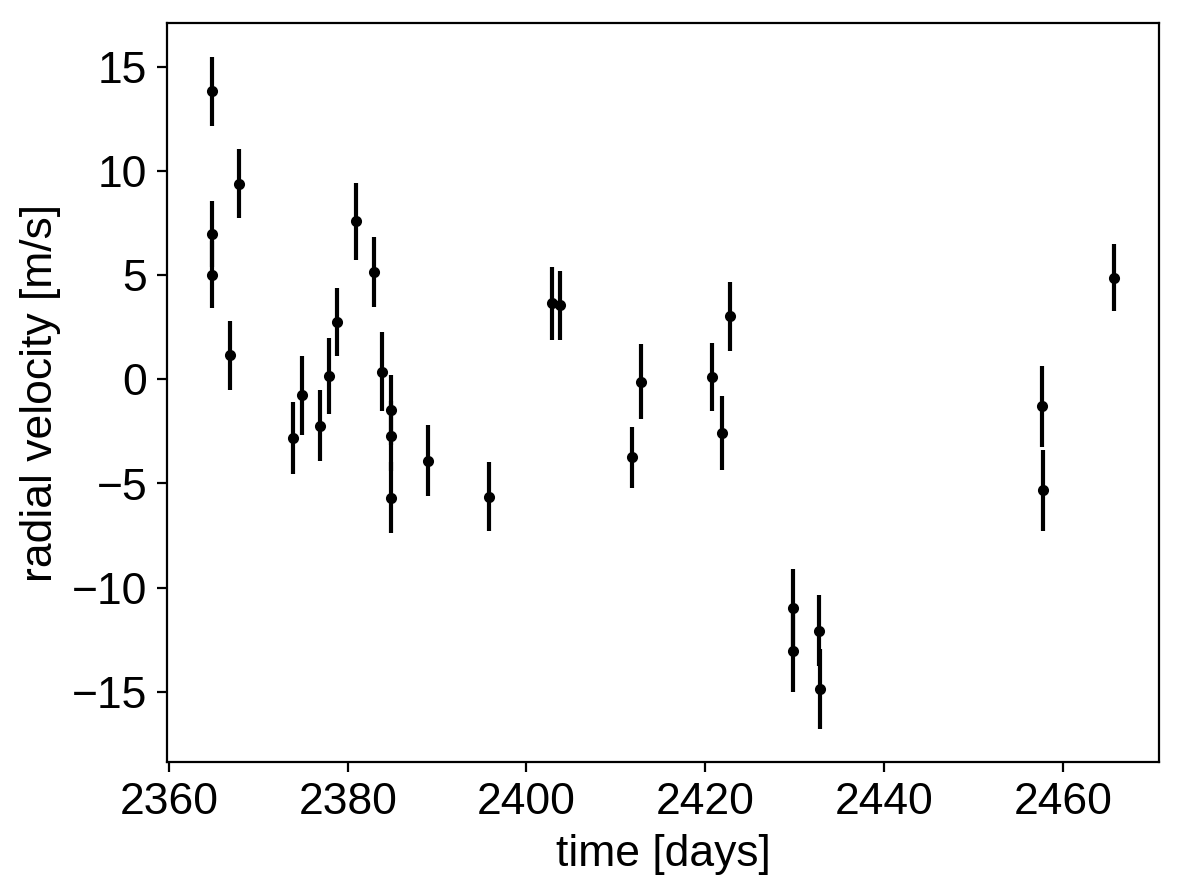

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)("P", mu=np.array(periods), sd=np.array(period_errs),
                                     shape=2, testval=np.array(periods))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)("logK", mu=np.log(Ks), sd=10.0,
                                        shape=2, testval=np.log(Ks))

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=2, testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

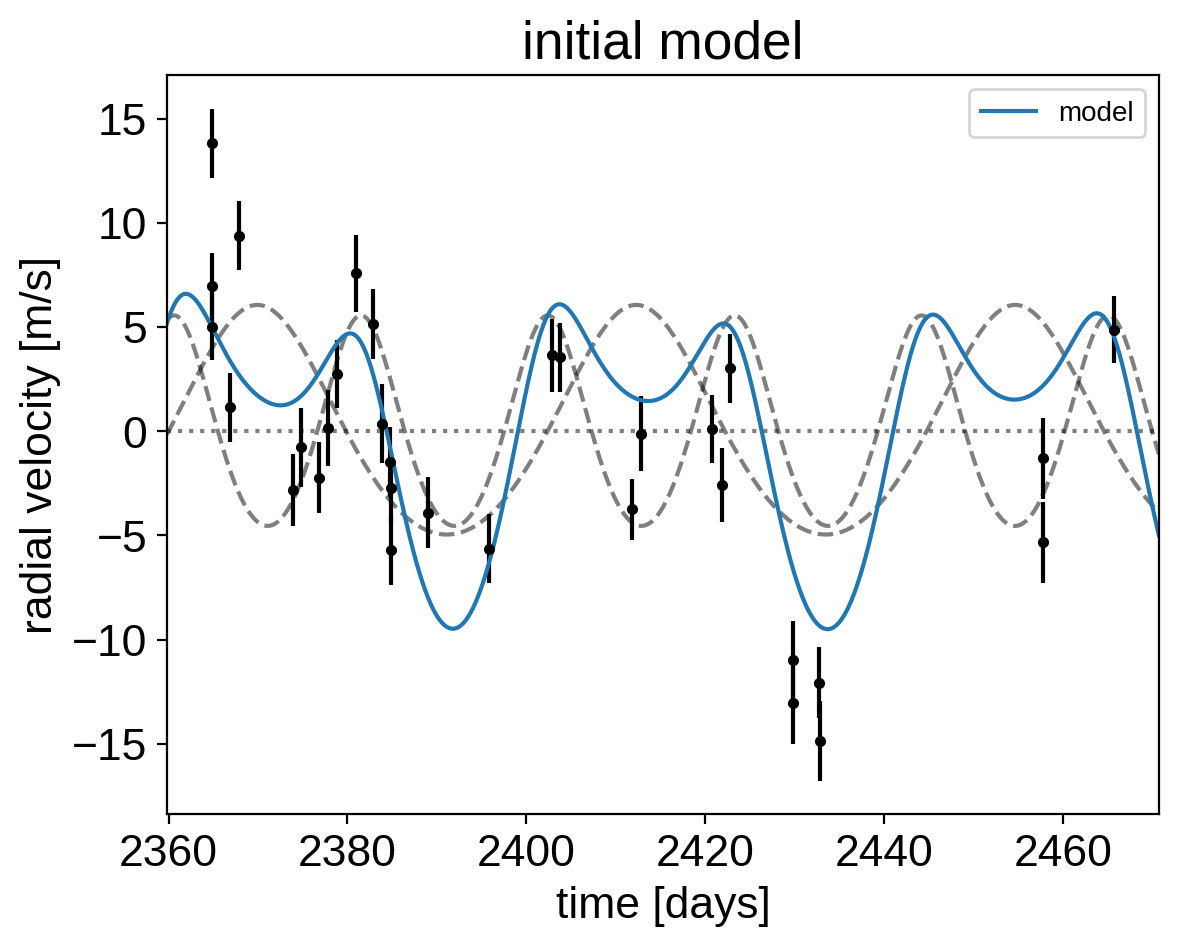

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -79.73266285618838 -> -64.8482026233154


optimizing logp for variables: ['trend', 'logs', 'omega_angle__', 'ecc_logodds__', 'logK_lowerbound__', 'P_lowerbound__', 't0']


message: Desired error not necessarily achieved due to precision loss.
logp: -64.8482026233154 -> -14.27676026238089


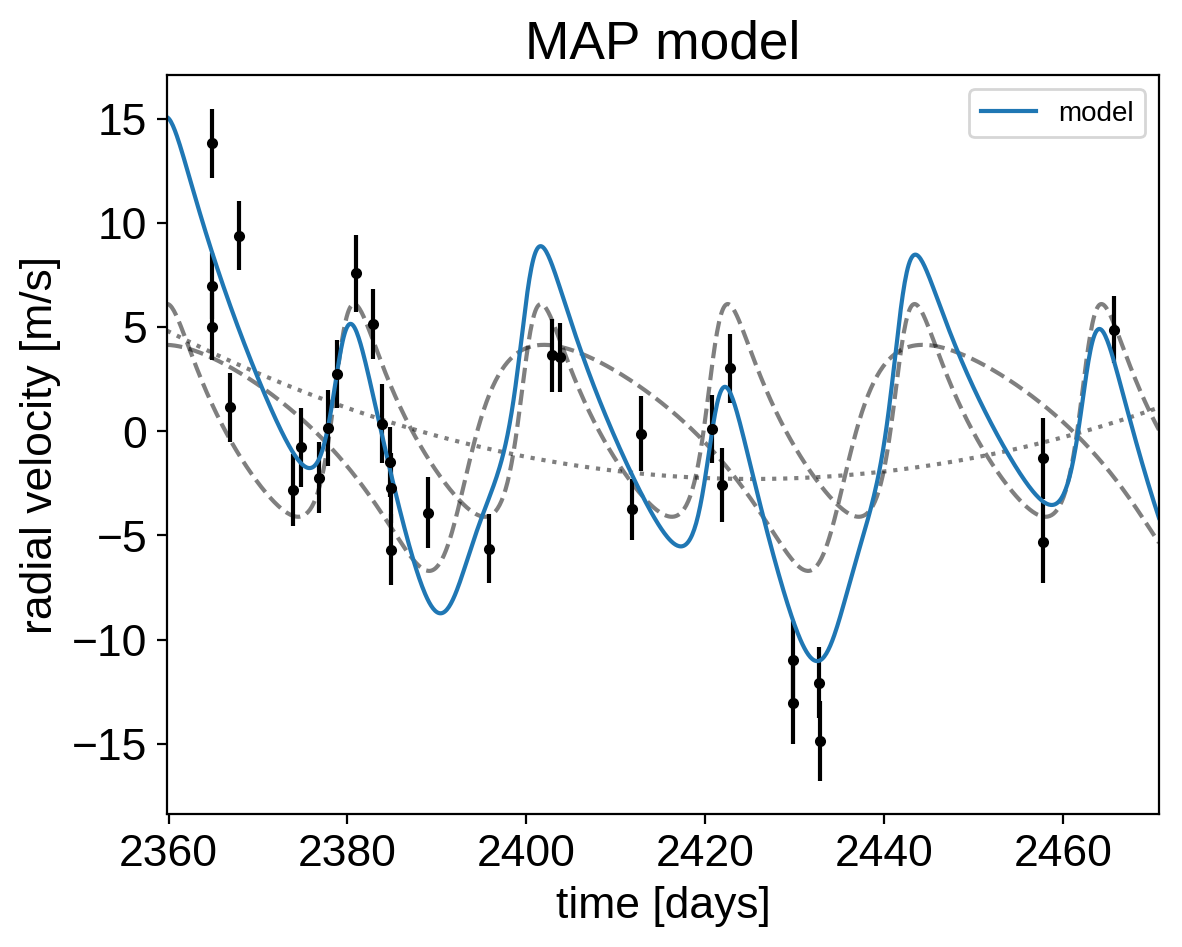

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:04, 195.96draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:00<00:06, 128.78draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:00<00:07, 108.82draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:00<00:07, 98.20draws/s] 

Sampling 4 chains:   7%|▋         | 53/808 [00:00<00:08, 93.54draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:00<00:07, 94.45draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:00<00:08, 84.15draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:00<00:08, 87.90draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:00<00:08, 87.82draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:01<00:08, 81.74draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:01<00:08, 86.05draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:01<00:08, 82.20draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:01<00:08, 82.78draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:01<00:07, 86.79draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:01<00:08, 80.01draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:01<00:07, 82.33draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:01<00:07, 85.82draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:01<00:07, 81.79draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:02<00:07, 81.11draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:02<00:07, 81.30draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:02<00:07, 83.28draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:02<00:07, 83.95draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:02<00:07, 81.83draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:02<00:06, 82.77draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:02<00:06, 85.72draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:02<00:06, 83.46draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:02<00:06, 83.91draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:03<00:06, 85.23draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:03<00:06, 81.72draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:03<00:06, 82.73draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:03<00:05, 86.02draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:03<00:06, 83.53draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:03<00:05, 83.21draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:03<00:05, 83.77draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:03<00:05, 82.75draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:03<00:05, 84.64draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:04<00:05, 85.38draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:04<00:05, 83.94draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:04<00:05, 83.84draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:04<00:05, 79.39draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:04<00:05, 79.72draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:04<00:04, 84.56draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:04<00:04, 82.61draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:04<00:04, 81.85draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:04<00:04, 82.06draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [00:05<00:04, 84.13draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:05<00:04, 85.66draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:05<00:04, 83.01draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:05<00:04, 82.84draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:05<00:04, 82.85draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:05<00:03, 83.47draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [00:05<00:03, 84.62draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:05<00:03, 85.56draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [00:05<00:03, 83.49draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:06<00:03, 82.45draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:06<00:03, 83.66draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:06<00:03, 83.43draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:06<00:03, 82.65draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:06<00:03, 81.89draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:06<00:02, 83.48draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [00:06<00:02, 84.96draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:06<00:02, 83.38draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:06<00:02, 83.81draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:07<00:02, 84.89draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:07<00:02, 83.97draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [00:07<00:02, 85.30draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:07<00:02, 81.83draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:07<00:01, 86.10draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:07<00:01, 81.50draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:07<00:01, 85.32draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:07<00:01, 81.67draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:07<00:01, 83.38draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [00:08<00:01, 85.56draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:08<00:01, 81.40draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:08<00:01, 83.68draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [00:08<00:01, 83.39draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:08<00:00, 85.23draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [00:08<00:00, 84.86draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [00:08<00:00, 81.32draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:08<00:00, 83.07draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:08<00:00, 84.73draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:09<00:00, 85.71draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:09<00:00, 81.60draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:09<00:00, 81.34draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:09<00:00, 61.95draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:09<00:00, 51.49draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:10<00:00, 78.47draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:01, 206.76draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:00<00:02, 141.06draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:02, 124.57draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:00<00:03, 115.41draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:00<00:03, 109.06draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:00<00:03, 101.98draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:00<00:03, 100.91draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:00<00:03, 96.86draws/s] 

Sampling 4 chains:  26%|██▌       | 106/408 [00:00<00:03, 97.95draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:01<00:02, 102.68draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:01<00:02, 101.37draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:01<00:02, 99.10draws/s] 

Sampling 4 chains:  37%|███▋      | 152/408 [00:01<00:02, 95.89draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:01<00:02, 95.50draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:01<00:02, 97.34draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:01<00:02, 94.46draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:01<00:02, 95.15draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:01<00:01, 104.04draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:02<00:02, 94.96draws/s] 

Sampling 4 chains:  56%|█████▋    | 230/408 [00:02<00:01, 99.42draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:02<00:01, 96.12draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:02<00:01, 97.22draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:02<00:01, 98.51draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:02<00:01, 93.88draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:02<00:01, 91.41draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:02<00:01, 94.45draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:03<00:01, 95.71draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:03<00:01, 92.79draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:03<00:00, 89.62draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:03<00:00, 94.82draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:03<00:00, 95.57draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:03<00:00, 92.75draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:03<00:00, 90.71draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:03<00:00, 89.22draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:03<00:00, 88.48draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:04<00:00, 85.28draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:04<00:00, 72.91draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:04<00:00, 90.78draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<00:12, 65.62draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<00:11, 66.51draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:11, 66.29draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:11, 68.95draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:10, 70.36draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:10, 72.69draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:00<00:09, 76.47draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:00<00:09, 79.63draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:00<00:09, 79.17draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:01<00:09, 78.23draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:01<00:08, 81.21draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:01<00:09, 77.98draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:01<00:08, 79.69draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:01<00:08, 78.67draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:01<00:08, 77.99draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:01<00:08, 77.86draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:01<00:08, 79.66draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:01<00:08, 79.65draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:01<00:08, 79.67draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:02<00:08, 77.39draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:02<00:08, 77.71draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:02<00:08, 77.95draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:02<00:07, 77.83draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:02<00:07, 80.94draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:02<00:07, 80.97draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:02<00:07, 81.84draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:02<00:07, 82.28draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:02<00:07, 81.40draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:03<00:06, 82.51draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:03<00:06, 84.02draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:03<00:06, 80.38draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:03<00:06, 82.57draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:03<00:06, 79.63draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:03<00:06, 78.10draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:03<00:06, 77.88draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:03<00:06, 78.35draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:03<00:06, 80.65draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:04<00:06, 81.19draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:04<00:05, 81.46draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:04<00:05, 82.74draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:04<00:05, 81.17draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:04<00:05, 77.43draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:04<00:05, 77.73draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:04<00:05, 79.55draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:04<00:05, 79.02draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:04<00:05, 79.29draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:05<00:05, 81.13draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:05<00:04, 83.09draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:05<00:04, 79.71draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:05<00:04, 79.39draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [00:05<00:04, 81.42draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:05<00:04, 79.38draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:05<00:04, 79.00draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:05<00:04, 78.68draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:05<00:04, 78.42draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:05<00:04, 78.70draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:06<00:03, 81.68draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:06<00:03, 83.07draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:06<00:03, 84.14draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:06<00:03, 85.18draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [00:06<00:03, 76.84draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [00:06<00:03, 80.11draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:06<00:03, 82.36draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:06<00:03, 81.60draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:06<00:03, 81.64draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:07<00:03, 80.33draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [00:07<00:02, 78.89draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:07<00:02, 81.79draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:07<00:02, 81.40draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:07<00:02, 83.35draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:07<00:02, 81.04draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:07<00:02, 83.12draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:07<00:02, 83.02draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:07<00:02, 80.68draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:08<00:02, 79.48draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:08<00:01, 80.44draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [00:08<00:01, 79.76draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:08<00:01, 79.53draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [00:08<00:01, 79.67draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [00:08<00:01, 81.83draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [00:08<00:01, 82.73draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:08<00:01, 79.22draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:08<00:01, 79.42draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:09<00:01, 79.01draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:09<00:00, 81.44draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:09<00:00, 81.57draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:09<00:00, 80.30draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [00:09<00:00, 79.23draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:09<00:00, 79.42draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:09<00:00, 78.94draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:09<00:00, 77.81draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:09<00:00, 77.14draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:10<00:00, 60.36draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:10<00:00, 76.80draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:00<00:04, 352.28draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:00<00:04, 369.64draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:00<00:03, 381.45draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:00<00:03, 376.59draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:00<00:03, 385.39draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:00<00:03, 362.79draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:00<00:03, 383.91draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [00:00<00:02, 428.71draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [00:00<00:02, 445.97draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:01<00:02, 436.90draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [00:01<00:02, 430.29draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [00:01<00:02, 381.14draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [00:01<00:02, 374.56draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:01<00:02, 386.57draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [00:01<00:02, 392.48draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [00:01<00:02, 387.26draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [00:01<00:02, 344.96draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [00:01<00:02, 331.53draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [00:02<00:02, 356.49draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [00:02<00:02, 366.51draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [00:02<00:02, 331.43draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [00:02<00:02, 321.92draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [00:02<00:02, 322.55draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [00:02<00:01, 329.95draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [00:02<00:01, 353.26draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [00:02<00:01, 353.63draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [00:02<00:01, 321.95draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [00:03<00:01, 321.79draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [00:03<00:01, 326.75draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [00:03<00:01, 327.55draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [00:03<00:01, 347.98draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [00:03<00:00, 374.58draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [00:03<00:00, 404.77draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [00:03<00:00, 428.98draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [00:03<00:00, 385.42draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [00:03<00:00, 348.31draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [00:04<00:00, 326.02draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [00:04<00:00, 272.76draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [00:04<00:00, 250.37draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:04<00:00, 349.38draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:00<00:07, 440.22draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:00<00:06, 468.67draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:00<00:06, 477.87draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:00<00:06, 480.54draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:00<00:07, 413.41draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:00<00:07, 412.13draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [00:00<00:07, 407.70draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [00:00<00:07, 376.79draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [00:00<00:07, 380.48draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [00:01<00:06, 395.73draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [00:01<00:06, 424.13draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [00:01<00:05, 460.57draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [00:01<00:05, 475.34draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [00:01<00:05, 494.57draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [00:01<00:05, 476.11draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [00:01<00:05, 482.61draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [00:01<00:05, 464.84draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [00:01<00:05, 458.04draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [00:02<00:05, 452.29draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [00:02<00:05, 418.95draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [00:02<00:05, 414.57draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [00:02<00:05, 413.53draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [00:02<00:04, 427.09draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [00:02<00:05, 414.13draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [00:02<00:05, 407.99draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [00:02<00:04, 428.18draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [00:02<00:04, 438.88draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [00:02<00:04, 435.38draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [00:03<00:03, 461.37draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [00:03<00:03, 469.32draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [00:03<00:03, 474.60draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [00:03<00:03, 457.40draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [00:03<00:03, 481.22draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [00:03<00:03, 499.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [00:03<00:03, 508.00draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [00:03<00:02, 508.17draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [00:03<00:02, 531.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [00:03<00:02, 531.45draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [00:04<00:02, 527.81draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [00:04<00:02, 534.49draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [00:04<00:02, 548.83draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [00:04<00:02, 552.08draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [00:04<00:02, 542.24draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [00:04<00:01, 534.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [00:04<00:01, 534.12draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [00:04<00:01, 515.10draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [00:04<00:01, 515.46draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [00:05<00:01, 518.16draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [00:05<00:01, 507.76draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [00:05<00:01, 462.82draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [00:05<00:01, 459.93draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [00:05<00:01, 477.64draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [00:05<00:01, 476.76draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [00:05<00:01, 479.60draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [00:05<00:00, 499.34draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [00:05<00:00, 522.14draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [00:06<00:00, 475.22draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [00:06<00:00, 346.52draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [00:06<00:00, 313.49draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [00:06<00:00, 289.09draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [00:06<00:00, 254.03draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [00:06<00:00, 247.82draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [00:06<00:00, 242.53draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [00:07<00:00, 255.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [00:07<00:00, 271.13draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [00:07<00:00, 229.69draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [00:07<00:00, 157.54draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:07<00:00, 413.07draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 34/9208 [00:00<00:28, 326.53draws/s]

Sampling 4 chains:   1%|          | 69/9208 [00:00<00:27, 330.20draws/s]

Sampling 4 chains:   1%|          | 114/9208 [00:00<00:25, 358.55draws/s]

Sampling 4 chains:   2%|▏         | 155/9208 [00:00<00:24, 368.53draws/s]

Sampling 4 chains:   2%|▏         | 200/9208 [00:00<00:23, 388.29draws/s]

Sampling 4 chains:   3%|▎         | 235/9208 [00:00<00:23, 375.06draws/s]

Sampling 4 chains:   3%|▎         | 270/9208 [00:00<00:25, 352.10draws/s]

Sampling 4 chains:   3%|▎         | 304/9208 [00:00<00:26, 339.20draws/s]

Sampling 4 chains:   4%|▎         | 344/9208 [00:00<00:24, 354.76draws/s]

Sampling 4 chains:   4%|▍         | 379/9208 [00:01<00:26, 335.67draws/s]

Sampling 4 chains:   5%|▍         | 423/9208 [00:01<00:24, 360.60draws/s]

Sampling 4 chains:   5%|▌         | 472/9208 [00:01<00:22, 390.89draws/s]

Sampling 4 chains:   6%|▌         | 516/9208 [00:01<00:21, 402.92draws/s]

Sampling 4 chains:   6%|▌         | 560/9208 [00:01<00:20, 411.91draws/s]

Sampling 4 chains:   7%|▋         | 602/9208 [00:01<00:23, 369.25draws/s]

Sampling 4 chains:   7%|▋         | 641/9208 [00:01<00:24, 348.06draws/s]

Sampling 4 chains:   7%|▋         | 677/9208 [00:01<00:25, 328.56draws/s]

Sampling 4 chains:   8%|▊         | 711/9208 [00:01<00:26, 322.57draws/s]

Sampling 4 chains:   8%|▊         | 744/9208 [00:02<00:26, 313.71draws/s]

Sampling 4 chains:   8%|▊         | 779/9208 [00:02<00:26, 322.24draws/s]

Sampling 4 chains:   9%|▉         | 814/9208 [00:02<00:25, 329.39draws/s]

Sampling 4 chains:   9%|▉         | 853/9208 [00:02<00:24, 344.42draws/s]

Sampling 4 chains:  10%|▉         | 897/9208 [00:02<00:22, 368.09draws/s]

Sampling 4 chains:  10%|█         | 936/9208 [00:02<00:22, 374.25draws/s]

Sampling 4 chains:  11%|█         | 974/9208 [00:02<00:22, 371.67draws/s]

Sampling 4 chains:  11%|█         | 1022/9208 [00:02<00:20, 396.64draws/s]

Sampling 4 chains:  12%|█▏        | 1063/9208 [00:02<00:20, 395.11draws/s]

Sampling 4 chains:  12%|█▏        | 1104/9208 [00:03<00:21, 376.77draws/s]

Sampling 4 chains:  12%|█▏        | 1144/9208 [00:03<00:21, 381.33draws/s]

Sampling 4 chains:  13%|█▎        | 1183/9208 [00:03<00:21, 371.34draws/s]

Sampling 4 chains:  13%|█▎        | 1221/9208 [00:03<00:22, 357.73draws/s]

Sampling 4 chains:  14%|█▎        | 1258/9208 [00:03<00:22, 347.38draws/s]

Sampling 4 chains:  14%|█▍        | 1294/9208 [00:03<00:24, 325.90draws/s]

Sampling 4 chains:  14%|█▍        | 1335/9208 [00:03<00:22, 345.89draws/s]

Sampling 4 chains:  15%|█▍        | 1376/9208 [00:03<00:21, 361.50draws/s]

Sampling 4 chains:  15%|█▌        | 1413/9208 [00:03<00:21, 362.99draws/s]

Sampling 4 chains:  16%|█▌        | 1451/9208 [00:03<00:21, 364.29draws/s]

Sampling 4 chains:  16%|█▌        | 1488/9208 [00:04<00:21, 352.45draws/s]

Sampling 4 chains:  17%|█▋        | 1524/9208 [00:04<00:21, 353.97draws/s]

Sampling 4 chains:  17%|█▋        | 1560/9208 [00:04<00:23, 332.29draws/s]

Sampling 4 chains:  17%|█▋        | 1594/9208 [00:04<00:23, 319.79draws/s]

Sampling 4 chains:  18%|█▊        | 1627/9208 [00:04<00:26, 281.83draws/s]

Sampling 4 chains:  18%|█▊        | 1657/9208 [00:04<00:28, 263.00draws/s]

Sampling 4 chains:  18%|█▊        | 1685/9208 [00:04<00:30, 244.56draws/s]

Sampling 4 chains:  19%|█▊        | 1711/9208 [00:04<00:31, 237.99draws/s]

Sampling 4 chains:  19%|█▉        | 1737/9208 [00:05<00:30, 242.86draws/s]

Sampling 4 chains:  19%|█▉        | 1775/9208 [00:05<00:27, 271.13draws/s]

Sampling 4 chains:  20%|█▉        | 1822/9208 [00:05<00:23, 309.51draws/s]

Sampling 4 chains:  20%|██        | 1870/9208 [00:05<00:21, 344.87draws/s]

Sampling 4 chains:  21%|██        | 1915/9208 [00:05<00:19, 367.54draws/s]

Sampling 4 chains:  21%|██▏       | 1960/9208 [00:05<00:18, 387.05draws/s]

Sampling 4 chains:  22%|██▏       | 2001/9208 [00:05<00:18, 388.34draws/s]

Sampling 4 chains:  22%|██▏       | 2042/9208 [00:05<00:20, 351.81draws/s]

Sampling 4 chains:  23%|██▎       | 2079/9208 [00:05<00:20, 344.65draws/s]

Sampling 4 chains:  23%|██▎       | 2117/9208 [00:06<00:20, 353.88draws/s]

Sampling 4 chains:  23%|██▎       | 2160/9208 [00:06<00:18, 372.21draws/s]

Sampling 4 chains:  24%|██▍       | 2211/9208 [00:06<00:17, 404.30draws/s]

Sampling 4 chains:  25%|██▍       | 2257/9208 [00:06<00:16, 418.13draws/s]

Sampling 4 chains:  25%|██▌       | 2304/9208 [00:06<00:16, 429.40draws/s]

Sampling 4 chains:  26%|██▌       | 2349/9208 [00:06<00:15, 433.38draws/s]

Sampling 4 chains:  26%|██▌       | 2394/9208 [00:06<00:15, 436.74draws/s]

Sampling 4 chains:  27%|██▋       | 2447/9208 [00:06<00:14, 461.06draws/s]

Sampling 4 chains:  27%|██▋       | 2500/9208 [00:06<00:13, 479.70draws/s]

Sampling 4 chains:  28%|██▊       | 2556/9208 [00:06<00:13, 501.19draws/s]

Sampling 4 chains:  28%|██▊       | 2607/9208 [00:07<00:13, 484.05draws/s]

Sampling 4 chains:  29%|██▉       | 2657/9208 [00:07<00:14, 459.98draws/s]

Sampling 4 chains:  29%|██▉       | 2704/9208 [00:07<00:14, 434.02draws/s]

Sampling 4 chains:  30%|██▉       | 2749/9208 [00:07<00:15, 410.01draws/s]

Sampling 4 chains:  30%|███       | 2794/9208 [00:07<00:15, 420.66draws/s]

Sampling 4 chains:  31%|███       | 2844/9208 [00:07<00:14, 439.40draws/s]

Sampling 4 chains:  31%|███▏      | 2900/9208 [00:07<00:13, 468.78draws/s]

Sampling 4 chains:  32%|███▏      | 2957/9208 [00:07<00:12, 494.19draws/s]

Sampling 4 chains:  33%|███▎      | 3013/9208 [00:07<00:12, 512.20draws/s]

Sampling 4 chains:  33%|███▎      | 3072/9208 [00:08<00:11, 533.17draws/s]

Sampling 4 chains:  34%|███▍      | 3127/9208 [00:08<00:11, 536.77draws/s]

Sampling 4 chains:  35%|███▍      | 3182/9208 [00:08<00:11, 529.51draws/s]

Sampling 4 chains:  35%|███▌      | 3243/9208 [00:08<00:10, 550.06draws/s]

Sampling 4 chains:  36%|███▌      | 3299/9208 [00:08<00:10, 551.59draws/s]

Sampling 4 chains:  36%|███▋      | 3355/9208 [00:08<00:11, 523.51draws/s]

Sampling 4 chains:  37%|███▋      | 3408/9208 [00:08<00:11, 498.14draws/s]

Sampling 4 chains:  38%|███▊      | 3459/9208 [00:08<00:11, 485.39draws/s]

Sampling 4 chains:  38%|███▊      | 3510/9208 [00:08<00:11, 492.00draws/s]

Sampling 4 chains:  39%|███▊      | 3564/9208 [00:08<00:11, 504.11draws/s]

Sampling 4 chains:  39%|███▉      | 3619/9208 [00:09<00:10, 515.66draws/s]

Sampling 4 chains:  40%|███▉      | 3675/9208 [00:09<00:10, 526.67draws/s]

Sampling 4 chains:  41%|████      | 3730/9208 [00:09<00:10, 531.51draws/s]

Sampling 4 chains:  41%|████      | 3786/9208 [00:09<00:10, 537.91draws/s]

Sampling 4 chains:  42%|████▏     | 3840/9208 [00:09<00:10, 526.32draws/s]

Sampling 4 chains:  42%|████▏     | 3893/9208 [00:09<00:10, 499.78draws/s]

Sampling 4 chains:  43%|████▎     | 3944/9208 [00:09<00:10, 492.34draws/s]

Sampling 4 chains:  43%|████▎     | 3994/9208 [00:09<00:10, 485.74draws/s]

Sampling 4 chains:  44%|████▍     | 4043/9208 [00:09<00:10, 484.56draws/s]

Sampling 4 chains:  44%|████▍     | 4092/9208 [00:10<00:10, 481.27draws/s]

Sampling 4 chains:  45%|████▍     | 4143/9208 [00:10<00:10, 486.13draws/s]

Sampling 4 chains:  46%|████▌     | 4193/9208 [00:10<00:10, 487.32draws/s]

Sampling 4 chains:  46%|████▌     | 4248/9208 [00:10<00:09, 504.30draws/s]

Sampling 4 chains:  47%|████▋     | 4305/9208 [00:10<00:09, 519.54draws/s]

Sampling 4 chains:  47%|████▋     | 4364/9208 [00:10<00:09, 537.44draws/s]

Sampling 4 chains:  48%|████▊     | 4419/9208 [00:10<00:09, 524.42draws/s]

Sampling 4 chains:  49%|████▊     | 4472/9208 [00:10<00:09, 524.16draws/s]

Sampling 4 chains:  49%|████▉     | 4525/9208 [00:10<00:09, 487.25draws/s]

Sampling 4 chains:  50%|████▉     | 4575/9208 [00:11<00:09, 470.38draws/s]

Sampling 4 chains:  50%|█████     | 4624/9208 [00:11<00:09, 474.42draws/s]

Sampling 4 chains:  51%|█████     | 4672/9208 [00:11<00:09, 459.79draws/s]

Sampling 4 chains:  51%|█████     | 4719/9208 [00:11<00:10, 439.98draws/s]

Sampling 4 chains:  52%|█████▏    | 4764/9208 [00:11<00:10, 430.65draws/s]

Sampling 4 chains:  52%|█████▏    | 4808/9208 [00:11<00:10, 415.92draws/s]

Sampling 4 chains:  53%|█████▎    | 4850/9208 [00:11<00:10, 402.19draws/s]

Sampling 4 chains:  53%|█████▎    | 4891/9208 [00:11<00:11, 383.90draws/s]

Sampling 4 chains:  54%|█████▎    | 4930/9208 [00:11<00:11, 380.94draws/s]

Sampling 4 chains:  54%|█████▍    | 4975/9208 [00:11<00:10, 398.50draws/s]

Sampling 4 chains:  55%|█████▍    | 5032/9208 [00:12<00:09, 436.67draws/s]

Sampling 4 chains:  55%|█████▌    | 5084/9208 [00:12<00:09, 455.79draws/s]

Sampling 4 chains:  56%|█████▌    | 5132/9208 [00:12<00:08, 460.99draws/s]

Sampling 4 chains:  56%|█████▌    | 5179/9208 [00:12<00:08, 459.49draws/s]

Sampling 4 chains:  57%|█████▋    | 5226/9208 [00:12<00:09, 433.63draws/s]

Sampling 4 chains:  57%|█████▋    | 5271/9208 [00:12<00:09, 427.44draws/s]

Sampling 4 chains:  58%|█████▊    | 5315/9208 [00:12<00:09, 425.98draws/s]

Sampling 4 chains:  58%|█████▊    | 5363/9208 [00:12<00:08, 440.60draws/s]

Sampling 4 chains:  59%|█████▉    | 5414/9208 [00:12<00:08, 459.34draws/s]

Sampling 4 chains:  59%|█████▉    | 5464/9208 [00:13<00:08, 467.78draws/s]

Sampling 4 chains:  60%|█████▉    | 5512/9208 [00:13<00:07, 470.51draws/s]

Sampling 4 chains:  60%|██████    | 5565/9208 [00:13<00:07, 481.90draws/s]

Sampling 4 chains:  61%|██████    | 5614/9208 [00:13<00:07, 482.69draws/s]

Sampling 4 chains:  62%|██████▏   | 5664/9208 [00:13<00:07, 487.74draws/s]

Sampling 4 chains:  62%|██████▏   | 5716/9208 [00:13<00:07, 493.58draws/s]

Sampling 4 chains:  63%|██████▎   | 5767/9208 [00:13<00:06, 496.49draws/s]

Sampling 4 chains:  63%|██████▎   | 5817/9208 [00:13<00:06, 487.67draws/s]

Sampling 4 chains:  64%|██████▎   | 5866/9208 [00:13<00:06, 482.86draws/s]

Sampling 4 chains:  64%|██████▍   | 5915/9208 [00:13<00:07, 466.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5962/9208 [00:14<00:07, 432.78draws/s]

Sampling 4 chains:  65%|██████▌   | 6006/9208 [00:14<00:07, 414.25draws/s]

Sampling 4 chains:  66%|██████▌   | 6050/9208 [00:14<00:07, 421.44draws/s]

Sampling 4 chains:  66%|██████▌   | 6096/9208 [00:14<00:07, 432.20draws/s]

Sampling 4 chains:  67%|██████▋   | 6140/9208 [00:14<00:07, 433.34draws/s]

Sampling 4 chains:  67%|██████▋   | 6184/9208 [00:14<00:07, 416.63draws/s]

Sampling 4 chains:  68%|██████▊   | 6226/9208 [00:14<00:07, 388.43draws/s]

Sampling 4 chains:  68%|██████▊   | 6266/9208 [00:14<00:07, 390.80draws/s]

Sampling 4 chains:  69%|██████▊   | 6312/9208 [00:14<00:07, 408.59draws/s]

Sampling 4 chains:  69%|██████▉   | 6362/9208 [00:15<00:06, 430.90draws/s]

Sampling 4 chains:  70%|██████▉   | 6406/9208 [00:15<00:06, 428.77draws/s]

Sampling 4 chains:  70%|███████   | 6453/9208 [00:15<00:06, 437.70draws/s]

Sampling 4 chains:  71%|███████   | 6504/9208 [00:15<00:05, 453.53draws/s]

Sampling 4 chains:  71%|███████   | 6560/9208 [00:15<00:05, 480.66draws/s]

Sampling 4 chains:  72%|███████▏  | 6619/9208 [00:15<00:05, 508.70draws/s]

Sampling 4 chains:  73%|███████▎  | 6679/9208 [00:15<00:04, 530.70draws/s]

Sampling 4 chains:  73%|███████▎  | 6733/9208 [00:15<00:04, 518.59draws/s]

Sampling 4 chains:  74%|███████▎  | 6786/9208 [00:15<00:04, 503.41draws/s]

Sampling 4 chains:  74%|███████▍  | 6843/9208 [00:15<00:04, 521.64draws/s]

Sampling 4 chains:  75%|███████▍  | 6897/9208 [00:16<00:04, 523.67draws/s]

Sampling 4 chains:  75%|███████▌  | 6950/9208 [00:16<00:04, 520.20draws/s]

Sampling 4 chains:  76%|███████▌  | 7003/9208 [00:16<00:04, 513.51draws/s]

Sampling 4 chains:  77%|███████▋  | 7055/9208 [00:16<00:04, 512.87draws/s]

Sampling 4 chains:  77%|███████▋  | 7110/9208 [00:16<00:04, 521.71draws/s]

Sampling 4 chains:  78%|███████▊  | 7163/9208 [00:16<00:03, 517.78draws/s]

Sampling 4 chains:  78%|███████▊  | 7215/9208 [00:16<00:03, 509.13draws/s]

Sampling 4 chains:  79%|███████▉  | 7267/9208 [00:16<00:03, 488.16draws/s]

Sampling 4 chains:  79%|███████▉  | 7317/9208 [00:16<00:03, 481.92draws/s]

Sampling 4 chains:  80%|███████▉  | 7366/9208 [00:17<00:04, 457.27draws/s]

Sampling 4 chains:  81%|████████  | 7413/9208 [00:17<00:03, 460.83draws/s]

Sampling 4 chains:  81%|████████  | 7465/9208 [00:17<00:03, 475.58draws/s]

Sampling 4 chains:  82%|████████▏ | 7516/9208 [00:17<00:03, 483.54draws/s]

Sampling 4 chains:  82%|████████▏ | 7566/9208 [00:17<00:03, 488.18draws/s]

Sampling 4 chains:  83%|████████▎ | 7621/9208 [00:17<00:03, 503.57draws/s]

Sampling 4 chains:  83%|████████▎ | 7672/9208 [00:17<00:03, 493.74draws/s]

Sampling 4 chains:  84%|████████▍ | 7728/9208 [00:17<00:02, 509.58draws/s]

Sampling 4 chains:  85%|████████▍ | 7784/9208 [00:17<00:02, 523.05draws/s]

Sampling 4 chains:  85%|████████▌ | 7841/9208 [00:17<00:02, 535.90draws/s]

Sampling 4 chains:  86%|████████▌ | 7895/9208 [00:18<00:02, 513.38draws/s]

Sampling 4 chains:  86%|████████▋ | 7947/9208 [00:18<00:02, 482.33draws/s]

Sampling 4 chains:  87%|████████▋ | 7996/9208 [00:18<00:02, 470.81draws/s]

Sampling 4 chains:  87%|████████▋ | 8044/9208 [00:18<00:02, 470.25draws/s]

Sampling 4 chains:  88%|████████▊ | 8092/9208 [00:18<00:02, 440.98draws/s]

Sampling 4 chains:  88%|████████▊ | 8137/9208 [00:18<00:02, 436.09draws/s]

Sampling 4 chains:  89%|████████▉ | 8189/9208 [00:18<00:02, 458.17draws/s]

Sampling 4 chains:  89%|████████▉ | 8239/9208 [00:18<00:02, 466.46draws/s]

Sampling 4 chains:  90%|█████████ | 8290/9208 [00:18<00:01, 476.78draws/s]

Sampling 4 chains:  91%|█████████ | 8339/9208 [00:19<00:01, 474.20draws/s]

Sampling 4 chains:  91%|█████████ | 8387/9208 [00:19<00:01, 421.75draws/s]

Sampling 4 chains:  92%|█████████▏| 8431/9208 [00:19<00:02, 374.17draws/s]

Sampling 4 chains:  92%|█████████▏| 8471/9208 [00:19<00:02, 356.78draws/s]

Sampling 4 chains:  92%|█████████▏| 8509/9208 [00:19<00:02, 333.64draws/s]

Sampling 4 chains:  93%|█████████▎| 8544/9208 [00:19<00:02, 330.59draws/s]

Sampling 4 chains:  93%|█████████▎| 8579/9208 [00:19<00:01, 321.92draws/s]

Sampling 4 chains:  94%|█████████▎| 8616/9208 [00:19<00:01, 333.33draws/s]

Sampling 4 chains:  94%|█████████▍| 8656/9208 [00:20<00:01, 348.78draws/s]

Sampling 4 chains:  94%|█████████▍| 8695/9208 [00:20<00:01, 359.03draws/s]

Sampling 4 chains:  95%|█████████▍| 8734/9208 [00:20<00:01, 366.91draws/s]

Sampling 4 chains:  95%|█████████▌| 8775/9208 [00:20<00:01, 374.82draws/s]

Sampling 4 chains:  96%|█████████▌| 8814/9208 [00:20<00:01, 378.48draws/s]

Sampling 4 chains:  96%|█████████▌| 8854/9208 [00:20<00:00, 382.40draws/s]

Sampling 4 chains:  97%|█████████▋| 8893/9208 [00:20<00:00, 381.34draws/s]

Sampling 4 chains:  97%|█████████▋| 8936/9208 [00:20<00:00, 393.10draws/s]

Sampling 4 chains:  98%|█████████▊| 8981/9208 [00:20<00:00, 406.09draws/s]

Sampling 4 chains:  98%|█████████▊| 9022/9208 [00:20<00:00, 401.19draws/s]

Sampling 4 chains:  98%|█████████▊| 9063/9208 [00:21<00:00, 394.71draws/s]

Sampling 4 chains:  99%|█████████▉| 9103/9208 [00:21<00:00, 362.58draws/s]

Sampling 4 chains:  99%|█████████▉| 9140/9208 [00:21<00:00, 337.51draws/s]

Sampling 4 chains: 100%|█████████▉| 9175/9208 [00:21<00:00, 331.22draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:21<00:00, 422.30draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 37/1208 [00:00<00:03, 369.53draws/s]

Sampling 4 chains:   7%|▋         | 86/1208 [00:00<00:02, 396.91draws/s]

Sampling 4 chains:  11%|█▏        | 137/1208 [00:00<00:02, 424.40draws/s]

Sampling 4 chains:  16%|█▌        | 194/1208 [00:00<00:02, 458.87draws/s]

Sampling 4 chains:  20%|██        | 244/1208 [00:00<00:02, 469.21draws/s]

Sampling 4 chains:  24%|██▎       | 286/1208 [00:00<00:02, 420.17draws/s]

Sampling 4 chains:  27%|██▋       | 332/1208 [00:00<00:02, 429.32draws/s]

Sampling 4 chains:  31%|███▏      | 378/1208 [00:00<00:01, 437.28draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [00:00<00:01, 439.58draws/s]

Sampling 4 chains:  39%|███▊      | 467/1208 [00:01<00:01, 401.21draws/s]

Sampling 4 chains:  42%|████▏     | 508/1208 [00:01<00:01, 384.22draws/s]

Sampling 4 chains:  45%|████▌     | 547/1208 [00:01<00:02, 328.03draws/s]

Sampling 4 chains:  48%|████▊     | 582/1208 [00:01<00:01, 321.29draws/s]

Sampling 4 chains:  51%|█████▏    | 621/1208 [00:01<00:01, 335.57draws/s]

Sampling 4 chains:  54%|█████▍    | 656/1208 [00:01<00:01, 326.34draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [00:01<00:01, 346.11draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [00:01<00:01, 364.98draws/s]

Sampling 4 chains:  64%|██████▍   | 779/1208 [00:01<00:01, 374.62draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [00:02<00:01, 385.03draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [00:02<00:00, 402.39draws/s]

Sampling 4 chains:  75%|███████▌  | 909/1208 [00:02<00:00, 408.50draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [00:02<00:00, 345.35draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [00:02<00:00, 323.29draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [00:02<00:00, 344.09draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [00:02<00:00, 379.40draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [00:02<00:00, 384.62draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [00:03<00:00, 351.22draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [00:03<00:00, 247.59draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:03<00:00, 358.11draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 36/16000 [00:00<00:44, 356.94draws/s]

Sampling 4 chains:   1%|          | 82/16000 [00:00<00:41, 381.66draws/s]

Sampling 4 chains:   1%|          | 130/16000 [00:00<00:39, 405.75draws/s]

Sampling 4 chains:   1%|          | 174/16000 [00:00<00:38, 414.60draws/s]

Sampling 4 chains:   1%|▏         | 227/16000 [00:00<00:35, 442.79draws/s]

Sampling 4 chains:   2%|▏         | 275/16000 [00:00<00:34, 452.16draws/s]

Sampling 4 chains:   2%|▏         | 320/16000 [00:00<00:35, 447.56draws/s]

Sampling 4 chains:   2%|▏         | 366/16000 [00:00<00:34, 449.75draws/s]

Sampling 4 chains:   3%|▎         | 410/16000 [00:00<00:35, 440.22draws/s]

Sampling 4 chains:   3%|▎         | 453/16000 [00:01<00:36, 425.55draws/s]

Sampling 4 chains:   3%|▎         | 500/16000 [00:01<00:35, 434.07draws/s]

Sampling 4 chains:   3%|▎         | 547/16000 [00:01<00:34, 441.86draws/s]

Sampling 4 chains:   4%|▎         | 593/16000 [00:01<00:34, 444.44draws/s]

Sampling 4 chains:   4%|▍         | 642/16000 [00:01<00:33, 455.37draws/s]

Sampling 4 chains:   4%|▍         | 693/16000 [00:01<00:32, 467.94draws/s]

Sampling 4 chains:   5%|▍         | 742/16000 [00:01<00:32, 470.14draws/s]

Sampling 4 chains:   5%|▍         | 790/16000 [00:01<00:32, 467.26draws/s]

Sampling 4 chains:   5%|▌         | 837/16000 [00:01<00:32, 465.73draws/s]

Sampling 4 chains:   6%|▌         | 884/16000 [00:01<00:33, 457.61draws/s]

Sampling 4 chains:   6%|▌         | 936/16000 [00:02<00:31, 473.77draws/s]

Sampling 4 chains:   6%|▌         | 989/16000 [00:02<00:30, 489.24draws/s]

Sampling 4 chains:   7%|▋         | 1041/16000 [00:02<00:30, 495.54draws/s]

Sampling 4 chains:   7%|▋         | 1092/16000 [00:02<00:29, 499.42draws/s]

Sampling 4 chains:   7%|▋         | 1143/16000 [00:02<00:30, 492.95draws/s]

Sampling 4 chains:   7%|▋         | 1193/16000 [00:02<00:30, 485.78draws/s]

Sampling 4 chains:   8%|▊         | 1245/16000 [00:02<00:29, 492.90draws/s]

Sampling 4 chains:   8%|▊         | 1299/16000 [00:02<00:29, 505.28draws/s]

Sampling 4 chains:   8%|▊         | 1350/16000 [00:02<00:29, 503.20draws/s]

Sampling 4 chains:   9%|▉         | 1401/16000 [00:02<00:29, 495.79draws/s]

Sampling 4 chains:   9%|▉         | 1451/16000 [00:03<00:29, 489.87draws/s]

Sampling 4 chains:   9%|▉         | 1501/16000 [00:03<00:30, 474.91draws/s]

Sampling 4 chains:  10%|▉         | 1549/16000 [00:03<00:30, 466.67draws/s]

Sampling 4 chains:  10%|▉         | 1597/16000 [00:03<00:30, 469.74draws/s]

Sampling 4 chains:  10%|█         | 1648/16000 [00:03<00:29, 480.94draws/s]

Sampling 4 chains:  11%|█         | 1701/16000 [00:03<00:28, 493.40draws/s]

Sampling 4 chains:  11%|█         | 1751/16000 [00:03<00:29, 482.10draws/s]

Sampling 4 chains:  11%|█▏        | 1800/16000 [00:03<00:29, 475.57draws/s]

Sampling 4 chains:  12%|█▏        | 1848/16000 [00:03<00:29, 475.07draws/s]

Sampling 4 chains:  12%|█▏        | 1900/16000 [00:04<00:29, 485.35draws/s]

Sampling 4 chains:  12%|█▏        | 1949/16000 [00:04<00:29, 473.95draws/s]

Sampling 4 chains:  12%|█▏        | 1997/16000 [00:04<00:31, 451.10draws/s]

Sampling 4 chains:  13%|█▎        | 2043/16000 [00:04<00:30, 451.12draws/s]

Sampling 4 chains:  13%|█▎        | 2089/16000 [00:04<00:31, 446.26draws/s]

Sampling 4 chains:  13%|█▎        | 2134/16000 [00:04<00:31, 438.35draws/s]

Sampling 4 chains:  14%|█▎        | 2183/16000 [00:04<00:30, 451.99draws/s]

Sampling 4 chains:  14%|█▍        | 2233/16000 [00:04<00:29, 464.84draws/s]

Sampling 4 chains:  14%|█▍        | 2289/16000 [00:04<00:28, 489.17draws/s]

Sampling 4 chains:  15%|█▍        | 2339/16000 [00:04<00:28, 486.19draws/s]

Sampling 4 chains:  15%|█▍        | 2389/16000 [00:05<00:27, 489.84draws/s]

Sampling 4 chains:  15%|█▌        | 2439/16000 [00:05<00:28, 469.02draws/s]

Sampling 4 chains:  16%|█▌        | 2487/16000 [00:05<00:28, 470.69draws/s]

Sampling 4 chains:  16%|█▌        | 2535/16000 [00:05<00:28, 470.28draws/s]

Sampling 4 chains:  16%|█▌        | 2586/16000 [00:05<00:27, 481.05draws/s]

Sampling 4 chains:  16%|█▋        | 2638/16000 [00:05<00:27, 489.95draws/s]

Sampling 4 chains:  17%|█▋        | 2688/16000 [00:05<00:29, 452.97draws/s]

Sampling 4 chains:  17%|█▋        | 2734/16000 [00:05<00:29, 450.02draws/s]

Sampling 4 chains:  17%|█▋        | 2781/16000 [00:05<00:29, 454.41draws/s]

Sampling 4 chains:  18%|█▊        | 2827/16000 [00:06<00:29, 451.70draws/s]

Sampling 4 chains:  18%|█▊        | 2873/16000 [00:06<00:29, 448.82draws/s]

Sampling 4 chains:  18%|█▊        | 2919/16000 [00:06<00:29, 449.18draws/s]

Sampling 4 chains:  19%|█▊        | 2971/16000 [00:06<00:27, 467.68draws/s]

Sampling 4 chains:  19%|█▉        | 3023/16000 [00:06<00:26, 480.92draws/s]

Sampling 4 chains:  19%|█▉        | 3075/16000 [00:06<00:26, 489.24draws/s]

Sampling 4 chains:  20%|█▉        | 3125/16000 [00:06<00:26, 481.48draws/s]

Sampling 4 chains:  20%|█▉        | 3175/16000 [00:06<00:26, 486.07draws/s]

Sampling 4 chains:  20%|██        | 3224/16000 [00:06<00:26, 477.58draws/s]

Sampling 4 chains:  20%|██        | 3273/16000 [00:06<00:26, 479.47draws/s]

Sampling 4 chains:  21%|██        | 3322/16000 [00:07<00:26, 478.93draws/s]

Sampling 4 chains:  21%|██        | 3370/16000 [00:07<00:26, 474.31draws/s]

Sampling 4 chains:  21%|██▏       | 3418/16000 [00:07<00:26, 473.45draws/s]

Sampling 4 chains:  22%|██▏       | 3466/16000 [00:07<00:26, 467.80draws/s]

Sampling 4 chains:  22%|██▏       | 3516/16000 [00:07<00:26, 475.07draws/s]

Sampling 4 chains:  22%|██▏       | 3564/16000 [00:07<00:26, 475.90draws/s]

Sampling 4 chains:  23%|██▎       | 3620/16000 [00:07<00:24, 495.57draws/s]

Sampling 4 chains:  23%|██▎       | 3670/16000 [00:07<00:25, 485.27draws/s]

Sampling 4 chains:  23%|██▎       | 3719/16000 [00:07<00:25, 473.98draws/s]

Sampling 4 chains:  24%|██▎       | 3767/16000 [00:07<00:26, 466.56draws/s]

Sampling 4 chains:  24%|██▍       | 3816/16000 [00:08<00:25, 471.71draws/s]

Sampling 4 chains:  24%|██▍       | 3866/16000 [00:08<00:25, 475.80draws/s]

Sampling 4 chains:  24%|██▍       | 3915/16000 [00:08<00:25, 478.53draws/s]

Sampling 4 chains:  25%|██▍       | 3964/16000 [00:08<00:25, 479.42draws/s]

Sampling 4 chains:  25%|██▌       | 4016/16000 [00:08<00:24, 487.27draws/s]

Sampling 4 chains:  25%|██▌       | 4068/16000 [00:08<00:24, 495.88draws/s]

Sampling 4 chains:  26%|██▌       | 4118/16000 [00:08<00:24, 481.23draws/s]

Sampling 4 chains:  26%|██▌       | 4170/16000 [00:08<00:24, 490.08draws/s]

Sampling 4 chains:  26%|██▋       | 4220/16000 [00:08<00:24, 480.45draws/s]

Sampling 4 chains:  27%|██▋       | 4272/16000 [00:09<00:23, 490.35draws/s]

Sampling 4 chains:  27%|██▋       | 4324/16000 [00:09<00:23, 498.47draws/s]

Sampling 4 chains:  27%|██▋       | 4376/16000 [00:09<00:23, 503.19draws/s]

Sampling 4 chains:  28%|██▊       | 4429/16000 [00:09<00:22, 509.03draws/s]

Sampling 4 chains:  28%|██▊       | 4480/16000 [00:09<00:22, 507.37draws/s]

Sampling 4 chains:  28%|██▊       | 4531/16000 [00:09<00:23, 493.59draws/s]

Sampling 4 chains:  29%|██▊       | 4582/16000 [00:09<00:23, 495.69draws/s]

Sampling 4 chains:  29%|██▉       | 4632/16000 [00:09<00:23, 479.04draws/s]

Sampling 4 chains:  29%|██▉       | 4684/16000 [00:09<00:23, 488.96draws/s]

Sampling 4 chains:  30%|██▉       | 4737/16000 [00:09<00:22, 498.43draws/s]

Sampling 4 chains:  30%|██▉       | 4788/16000 [00:10<00:22, 488.26draws/s]

Sampling 4 chains:  30%|███       | 4837/16000 [00:10<00:23, 480.44draws/s]

Sampling 4 chains:  31%|███       | 4887/16000 [00:10<00:22, 484.85draws/s]

Sampling 4 chains:  31%|███       | 4940/16000 [00:10<00:22, 495.59draws/s]

Sampling 4 chains:  31%|███       | 4991/16000 [00:10<00:22, 498.48draws/s]

Sampling 4 chains:  32%|███▏      | 5043/16000 [00:10<00:21, 502.75draws/s]

Sampling 4 chains:  32%|███▏      | 5094/16000 [00:10<00:22, 490.47draws/s]

Sampling 4 chains:  32%|███▏      | 5145/16000 [00:10<00:21, 496.00draws/s]

Sampling 4 chains:  32%|███▏      | 5195/16000 [00:10<00:21, 491.50draws/s]

Sampling 4 chains:  33%|███▎      | 5247/16000 [00:10<00:21, 498.60draws/s]

Sampling 4 chains:  33%|███▎      | 5299/16000 [00:11<00:21, 503.99draws/s]

Sampling 4 chains:  33%|███▎      | 5351/16000 [00:11<00:20, 507.22draws/s]

Sampling 4 chains:  34%|███▍      | 5402/16000 [00:11<00:21, 484.03draws/s]

Sampling 4 chains:  34%|███▍      | 5451/16000 [00:11<00:21, 480.36draws/s]

Sampling 4 chains:  34%|███▍      | 5501/16000 [00:11<00:21, 485.51draws/s]

Sampling 4 chains:  35%|███▍      | 5550/16000 [00:11<00:22, 461.79draws/s]

Sampling 4 chains:  35%|███▍      | 5597/16000 [00:11<00:22, 461.07draws/s]

Sampling 4 chains:  35%|███▌      | 5644/16000 [00:11<00:22, 460.67draws/s]

Sampling 4 chains:  36%|███▌      | 5692/16000 [00:11<00:22, 465.55draws/s]

Sampling 4 chains:  36%|███▌      | 5739/16000 [00:12<00:22, 459.77draws/s]

Sampling 4 chains:  36%|███▌      | 5786/16000 [00:12<00:22, 459.29draws/s]

Sampling 4 chains:  36%|███▋      | 5835/16000 [00:12<00:21, 467.60draws/s]

Sampling 4 chains:  37%|███▋      | 5882/16000 [00:12<00:21, 463.58draws/s]

Sampling 4 chains:  37%|███▋      | 5929/16000 [00:12<00:21, 462.69draws/s]

Sampling 4 chains:  37%|███▋      | 5977/16000 [00:12<00:21, 466.70draws/s]

Sampling 4 chains:  38%|███▊      | 6024/16000 [00:12<00:21, 458.49draws/s]

Sampling 4 chains:  38%|███▊      | 6070/16000 [00:12<00:22, 451.33draws/s]

Sampling 4 chains:  38%|███▊      | 6122/16000 [00:12<00:21, 467.93draws/s]

Sampling 4 chains:  39%|███▊      | 6172/16000 [00:12<00:20, 476.62draws/s]

Sampling 4 chains:  39%|███▉      | 6224/16000 [00:13<00:20, 487.89draws/s]

Sampling 4 chains:  39%|███▉      | 6275/16000 [00:13<00:19, 492.23draws/s]

Sampling 4 chains:  40%|███▉      | 6326/16000 [00:13<00:19, 495.51draws/s]

Sampling 4 chains:  40%|███▉      | 6378/16000 [00:13<00:19, 499.26draws/s]

Sampling 4 chains:  40%|████      | 6431/16000 [00:13<00:18, 507.84draws/s]

Sampling 4 chains:  41%|████      | 6482/16000 [00:13<00:18, 506.55draws/s]

Sampling 4 chains:  41%|████      | 6533/16000 [00:13<00:20, 466.62draws/s]

Sampling 4 chains:  41%|████      | 6581/16000 [00:13<00:20, 469.55draws/s]

Sampling 4 chains:  41%|████▏     | 6629/16000 [00:13<00:20, 465.46draws/s]

Sampling 4 chains:  42%|████▏     | 6679/16000 [00:14<00:19, 474.65draws/s]

Sampling 4 chains:  42%|████▏     | 6727/16000 [00:14<00:19, 475.17draws/s]

Sampling 4 chains:  42%|████▏     | 6778/16000 [00:14<00:19, 483.72draws/s]

Sampling 4 chains:  43%|████▎     | 6829/16000 [00:14<00:18, 489.46draws/s]

Sampling 4 chains:  43%|████▎     | 6879/16000 [00:14<00:18, 488.35draws/s]

Sampling 4 chains:  43%|████▎     | 6929/16000 [00:14<00:18, 490.42draws/s]

Sampling 4 chains:  44%|████▎     | 6980/16000 [00:14<00:18, 493.05draws/s]

Sampling 4 chains:  44%|████▍     | 7030/16000 [00:14<00:18, 478.96draws/s]

Sampling 4 chains:  44%|████▍     | 7079/16000 [00:14<00:18, 479.44draws/s]

Sampling 4 chains:  45%|████▍     | 7128/16000 [00:14<00:18, 476.71draws/s]

Sampling 4 chains:  45%|████▍     | 7177/16000 [00:15<00:18, 480.35draws/s]

Sampling 4 chains:  45%|████▌     | 7227/16000 [00:15<00:18, 485.13draws/s]

Sampling 4 chains:  45%|████▌     | 7278/16000 [00:15<00:17, 487.46draws/s]

Sampling 4 chains:  46%|████▌     | 7330/16000 [00:15<00:17, 496.56draws/s]

Sampling 4 chains:  46%|████▌     | 7383/16000 [00:15<00:17, 504.82draws/s]

Sampling 4 chains:  46%|████▋     | 7434/16000 [00:15<00:17, 503.76draws/s]

Sampling 4 chains:  47%|████▋     | 7485/16000 [00:15<00:17, 492.14draws/s]

Sampling 4 chains:  47%|████▋     | 7535/16000 [00:15<00:17, 493.03draws/s]

Sampling 4 chains:  47%|████▋     | 7585/16000 [00:15<00:17, 486.65draws/s]

Sampling 4 chains:  48%|████▊     | 7636/16000 [00:15<00:17, 491.54draws/s]

Sampling 4 chains:  48%|████▊     | 7686/16000 [00:16<00:17, 481.64draws/s]

Sampling 4 chains:  48%|████▊     | 7736/16000 [00:16<00:16, 486.63draws/s]

Sampling 4 chains:  49%|████▊     | 7785/16000 [00:16<00:17, 478.80draws/s]

Sampling 4 chains:  49%|████▉     | 7833/16000 [00:16<00:17, 472.67draws/s]

Sampling 4 chains:  49%|████▉     | 7882/16000 [00:16<00:17, 475.96draws/s]

Sampling 4 chains:  50%|████▉     | 7930/16000 [00:16<00:17, 468.76draws/s]

Sampling 4 chains:  50%|████▉     | 7978/16000 [00:16<00:17, 470.75draws/s]

Sampling 4 chains:  50%|█████     | 8031/16000 [00:16<00:16, 485.24draws/s]

Sampling 4 chains:  50%|█████     | 8080/16000 [00:16<00:16, 478.05draws/s]

Sampling 4 chains:  51%|█████     | 8128/16000 [00:17<00:16, 476.15draws/s]

Sampling 4 chains:  51%|█████     | 8176/16000 [00:17<00:16, 474.98draws/s]

Sampling 4 chains:  51%|█████▏    | 8224/16000 [00:17<00:16, 473.63draws/s]

Sampling 4 chains:  52%|█████▏    | 8272/16000 [00:17<00:16, 468.78draws/s]

Sampling 4 chains:  52%|█████▏    | 8319/16000 [00:17<00:16, 457.57draws/s]

Sampling 4 chains:  52%|█████▏    | 8367/16000 [00:17<00:16, 462.82draws/s]

Sampling 4 chains:  53%|█████▎    | 8415/16000 [00:17<00:16, 465.85draws/s]

Sampling 4 chains:  53%|█████▎    | 8467/16000 [00:17<00:15, 479.95draws/s]

Sampling 4 chains:  53%|█████▎    | 8517/16000 [00:17<00:15, 485.53draws/s]

Sampling 4 chains:  54%|█████▎    | 8568/16000 [00:17<00:15, 490.25draws/s]

Sampling 4 chains:  54%|█████▍    | 8621/16000 [00:18<00:14, 496.94draws/s]

Sampling 4 chains:  54%|█████▍    | 8671/16000 [00:18<00:14, 493.03draws/s]

Sampling 4 chains:  55%|█████▍    | 8721/16000 [00:18<00:14, 489.89draws/s]

Sampling 4 chains:  55%|█████▍    | 8775/16000 [00:18<00:14, 502.07draws/s]

Sampling 4 chains:  55%|█████▌    | 8826/16000 [00:18<00:14, 489.41draws/s]

Sampling 4 chains:  55%|█████▌    | 8876/16000 [00:18<00:14, 487.80draws/s]

Sampling 4 chains:  56%|█████▌    | 8926/16000 [00:18<00:14, 490.44draws/s]

Sampling 4 chains:  56%|█████▌    | 8976/16000 [00:18<00:14, 492.79draws/s]

Sampling 4 chains:  56%|█████▋    | 9026/16000 [00:18<00:14, 492.21draws/s]

Sampling 4 chains:  57%|█████▋    | 9078/16000 [00:18<00:13, 499.32draws/s]

Sampling 4 chains:  57%|█████▋    | 9128/16000 [00:19<00:14, 482.86draws/s]

Sampling 4 chains:  57%|█████▋    | 9177/16000 [00:19<00:14, 483.71draws/s]

Sampling 4 chains:  58%|█████▊    | 9227/16000 [00:19<00:13, 487.21draws/s]

Sampling 4 chains:  58%|█████▊    | 9276/16000 [00:19<00:14, 476.59draws/s]

Sampling 4 chains:  58%|█████▊    | 9325/16000 [00:19<00:13, 480.16draws/s]

Sampling 4 chains:  59%|█████▊    | 9374/16000 [00:19<00:14, 471.90draws/s]

Sampling 4 chains:  59%|█████▉    | 9426/16000 [00:19<00:13, 481.25draws/s]

Sampling 4 chains:  59%|█████▉    | 9475/16000 [00:19<00:13, 467.33draws/s]

Sampling 4 chains:  60%|█████▉    | 9526/16000 [00:19<00:13, 477.59draws/s]

Sampling 4 chains:  60%|█████▉    | 9574/16000 [00:20<00:13, 472.90draws/s]

Sampling 4 chains:  60%|██████    | 9622/16000 [00:20<00:13, 470.14draws/s]

Sampling 4 chains:  60%|██████    | 9672/16000 [00:20<00:13, 476.79draws/s]

Sampling 4 chains:  61%|██████    | 9724/16000 [00:20<00:12, 488.68draws/s]

Sampling 4 chains:  61%|██████    | 9775/16000 [00:20<00:12, 493.81draws/s]

Sampling 4 chains:  61%|██████▏   | 9828/16000 [00:20<00:12, 501.01draws/s]

Sampling 4 chains:  62%|██████▏   | 9879/16000 [00:20<00:12, 489.61draws/s]

Sampling 4 chains:  62%|██████▏   | 9929/16000 [00:20<00:12, 485.81draws/s]

Sampling 4 chains:  62%|██████▏   | 9978/16000 [00:20<00:13, 460.75draws/s]

Sampling 4 chains:  63%|██████▎   | 10025/16000 [00:20<00:12, 462.54draws/s]

Sampling 4 chains:  63%|██████▎   | 10074/16000 [00:21<00:12, 468.65draws/s]

Sampling 4 chains:  63%|██████▎   | 10123/16000 [00:21<00:12, 474.63draws/s]

Sampling 4 chains:  64%|██████▎   | 10171/16000 [00:21<00:12, 471.27draws/s]

Sampling 4 chains:  64%|██████▍   | 10220/16000 [00:21<00:12, 476.21draws/s]

Sampling 4 chains:  64%|██████▍   | 10273/16000 [00:21<00:11, 489.22draws/s]

Sampling 4 chains:  65%|██████▍   | 10323/16000 [00:21<00:11, 489.27draws/s]

Sampling 4 chains:  65%|██████▍   | 10373/16000 [00:21<00:11, 479.45draws/s]

Sampling 4 chains:  65%|██████▌   | 10428/16000 [00:21<00:11, 496.88draws/s]

Sampling 4 chains:  66%|██████▌   | 10482/16000 [00:21<00:10, 507.34draws/s]

Sampling 4 chains:  66%|██████▌   | 10533/16000 [00:21<00:11, 492.99draws/s]

Sampling 4 chains:  66%|██████▌   | 10583/16000 [00:22<00:11, 478.14draws/s]

Sampling 4 chains:  66%|██████▋   | 10632/16000 [00:22<00:11, 471.51draws/s]

Sampling 4 chains:  67%|██████▋   | 10683/16000 [00:22<00:11, 479.84draws/s]

Sampling 4 chains:  67%|██████▋   | 10734/16000 [00:22<00:10, 487.42draws/s]

Sampling 4 chains:  67%|██████▋   | 10783/16000 [00:22<00:11, 464.00draws/s]

Sampling 4 chains:  68%|██████▊   | 10831/16000 [00:22<00:11, 467.04draws/s]

Sampling 4 chains:  68%|██████▊   | 10881/16000 [00:22<00:10, 475.38draws/s]

Sampling 4 chains:  68%|██████▊   | 10931/16000 [00:22<00:10, 480.39draws/s]

Sampling 4 chains:  69%|██████▊   | 10981/16000 [00:22<00:10, 483.60draws/s]

Sampling 4 chains:  69%|██████▉   | 11030/16000 [00:23<00:10, 463.36draws/s]

Sampling 4 chains:  69%|██████▉   | 11077/16000 [00:23<00:11, 444.68draws/s]

Sampling 4 chains:  70%|██████▉   | 11122/16000 [00:23<00:10, 445.97draws/s]

Sampling 4 chains:  70%|██████▉   | 11168/16000 [00:23<00:10, 449.19draws/s]

Sampling 4 chains:  70%|███████   | 11219/16000 [00:23<00:10, 464.57draws/s]

Sampling 4 chains:  70%|███████   | 11267/16000 [00:23<00:10, 466.56draws/s]

Sampling 4 chains:  71%|███████   | 11316/16000 [00:23<00:09, 469.58draws/s]

Sampling 4 chains:  71%|███████   | 11367/16000 [00:23<00:09, 480.09draws/s]

Sampling 4 chains:  71%|███████▏  | 11416/16000 [00:23<00:09, 482.85draws/s]

Sampling 4 chains:  72%|███████▏  | 11473/16000 [00:23<00:09, 500.80draws/s]

Sampling 4 chains:  72%|███████▏  | 11524/16000 [00:24<00:09, 494.60draws/s]

Sampling 4 chains:  72%|███████▏  | 11574/16000 [00:24<00:09, 488.39draws/s]

Sampling 4 chains:  73%|███████▎  | 11623/16000 [00:24<00:08, 488.72draws/s]

Sampling 4 chains:  73%|███████▎  | 11672/16000 [00:24<00:08, 485.31draws/s]

Sampling 4 chains:  73%|███████▎  | 11721/16000 [00:24<00:08, 477.23draws/s]

Sampling 4 chains:  74%|███████▎  | 11769/16000 [00:24<00:09, 464.16draws/s]

Sampling 4 chains:  74%|███████▍  | 11818/16000 [00:24<00:08, 469.13draws/s]

Sampling 4 chains:  74%|███████▍  | 11871/16000 [00:24<00:08, 485.09draws/s]

Sampling 4 chains:  74%|███████▍  | 11920/16000 [00:24<00:08, 459.06draws/s]

Sampling 4 chains:  75%|███████▍  | 11972/16000 [00:25<00:08, 474.80draws/s]

Sampling 4 chains:  75%|███████▌  | 12020/16000 [00:25<00:08, 474.01draws/s]

Sampling 4 chains:  75%|███████▌  | 12068/16000 [00:25<00:08, 475.69draws/s]

Sampling 4 chains:  76%|███████▌  | 12116/16000 [00:25<00:08, 470.43draws/s]

Sampling 4 chains:  76%|███████▌  | 12164/16000 [00:25<00:08, 469.56draws/s]

Sampling 4 chains:  76%|███████▋  | 12214/16000 [00:25<00:07, 477.68draws/s]

Sampling 4 chains:  77%|███████▋  | 12263/16000 [00:25<00:07, 479.73draws/s]

Sampling 4 chains:  77%|███████▋  | 12312/16000 [00:25<00:07, 479.12draws/s]

Sampling 4 chains:  77%|███████▋  | 12361/16000 [00:25<00:07, 480.03draws/s]

Sampling 4 chains:  78%|███████▊  | 12412/16000 [00:25<00:07, 486.54draws/s]

Sampling 4 chains:  78%|███████▊  | 12461/16000 [00:26<00:07, 473.47draws/s]

Sampling 4 chains:  78%|███████▊  | 12511/16000 [00:26<00:07, 475.49draws/s]

Sampling 4 chains:  78%|███████▊  | 12559/16000 [00:26<00:07, 457.80draws/s]

Sampling 4 chains:  79%|███████▉  | 12609/16000 [00:26<00:07, 467.49draws/s]

Sampling 4 chains:  79%|███████▉  | 12659/16000 [00:26<00:07, 476.43draws/s]

Sampling 4 chains:  79%|███████▉  | 12707/16000 [00:26<00:06, 474.55draws/s]

Sampling 4 chains:  80%|███████▉  | 12755/16000 [00:26<00:06, 474.21draws/s]

Sampling 4 chains:  80%|████████  | 12805/16000 [00:26<00:06, 481.12draws/s]

Sampling 4 chains:  80%|████████  | 12854/16000 [00:26<00:06, 478.51draws/s]

Sampling 4 chains:  81%|████████  | 12905/16000 [00:26<00:06, 487.07draws/s]

Sampling 4 chains:  81%|████████  | 12955/16000 [00:27<00:06, 490.85draws/s]

Sampling 4 chains:  81%|████████▏ | 13007/16000 [00:27<00:06, 498.43draws/s]

Sampling 4 chains:  82%|████████▏ | 13059/16000 [00:27<00:05, 504.62draws/s]

Sampling 4 chains:  82%|████████▏ | 13111/16000 [00:27<00:05, 506.26draws/s]

Sampling 4 chains:  82%|████████▏ | 13162/16000 [00:27<00:05, 488.46draws/s]

Sampling 4 chains:  83%|████████▎ | 13212/16000 [00:27<00:05, 474.66draws/s]

Sampling 4 chains:  83%|████████▎ | 13260/16000 [00:27<00:05, 467.35draws/s]

Sampling 4 chains:  83%|████████▎ | 13307/16000 [00:27<00:05, 458.55draws/s]

Sampling 4 chains:  83%|████████▎ | 13359/16000 [00:27<00:05, 473.17draws/s]

Sampling 4 chains:  84%|████████▍ | 13407/16000 [00:28<00:05, 462.64draws/s]

Sampling 4 chains:  84%|████████▍ | 13454/16000 [00:28<00:05, 464.47draws/s]

Sampling 4 chains:  84%|████████▍ | 13502/16000 [00:28<00:05, 466.96draws/s]

Sampling 4 chains:  85%|████████▍ | 13549/16000 [00:28<00:05, 464.88draws/s]

Sampling 4 chains:  85%|████████▍ | 13596/16000 [00:28<00:05, 458.15draws/s]

Sampling 4 chains:  85%|████████▌ | 13646/16000 [00:28<00:05, 468.94draws/s]

Sampling 4 chains:  86%|████████▌ | 13694/16000 [00:28<00:05, 460.56draws/s]

Sampling 4 chains:  86%|████████▌ | 13742/16000 [00:28<00:04, 465.84draws/s]

Sampling 4 chains:  86%|████████▌ | 13796/16000 [00:28<00:04, 484.64draws/s]

Sampling 4 chains:  87%|████████▋ | 13848/16000 [00:28<00:04, 494.44draws/s]

Sampling 4 chains:  87%|████████▋ | 13899/16000 [00:29<00:04, 494.64draws/s]

Sampling 4 chains:  87%|████████▋ | 13949/16000 [00:29<00:04, 493.06draws/s]

Sampling 4 chains:  87%|████████▋ | 13999/16000 [00:29<00:04, 483.10draws/s]

Sampling 4 chains:  88%|████████▊ | 14048/16000 [00:29<00:04, 475.75draws/s]

Sampling 4 chains:  88%|████████▊ | 14099/16000 [00:29<00:03, 483.19draws/s]

Sampling 4 chains:  88%|████████▊ | 14150/16000 [00:29<00:03, 489.52draws/s]

Sampling 4 chains:  89%|████████▉ | 14200/16000 [00:29<00:03, 477.06draws/s]

Sampling 4 chains:  89%|████████▉ | 14253/16000 [00:29<00:03, 491.64draws/s]

Sampling 4 chains:  89%|████████▉ | 14306/16000 [00:29<00:03, 495.84draws/s]

Sampling 4 chains:  90%|████████▉ | 14356/16000 [00:29<00:03, 485.51draws/s]

Sampling 4 chains:  90%|█████████ | 14407/16000 [00:30<00:03, 492.11draws/s]

Sampling 4 chains:  90%|█████████ | 14457/16000 [00:30<00:03, 483.35draws/s]

Sampling 4 chains:  91%|█████████ | 14506/16000 [00:30<00:03, 476.53draws/s]

Sampling 4 chains:  91%|█████████ | 14555/16000 [00:30<00:03, 478.18draws/s]

Sampling 4 chains:  91%|█████████▏| 14603/16000 [00:30<00:02, 472.28draws/s]

Sampling 4 chains:  92%|█████████▏| 14652/16000 [00:30<00:02, 475.88draws/s]

Sampling 4 chains:  92%|█████████▏| 14700/16000 [00:30<00:02, 474.75draws/s]

Sampling 4 chains:  92%|█████████▏| 14749/16000 [00:30<00:02, 478.57draws/s]

Sampling 4 chains:  92%|█████████▏| 14797/16000 [00:30<00:02, 460.32draws/s]

Sampling 4 chains:  93%|█████████▎| 14844/16000 [00:31<00:02, 458.83draws/s]

Sampling 4 chains:  93%|█████████▎| 14891/16000 [00:31<00:02, 452.56draws/s]

Sampling 4 chains:  93%|█████████▎| 14944/16000 [00:31<00:02, 472.77draws/s]

Sampling 4 chains:  94%|█████████▎| 14996/16000 [00:31<00:02, 484.71draws/s]

Sampling 4 chains:  94%|█████████▍| 15045/16000 [00:31<00:02, 472.73draws/s]

Sampling 4 chains:  94%|█████████▍| 15093/16000 [00:31<00:01, 456.74draws/s]

Sampling 4 chains:  95%|█████████▍| 15140/16000 [00:31<00:01, 458.57draws/s]

Sampling 4 chains:  95%|█████████▍| 15189/16000 [00:31<00:01, 465.67draws/s]

Sampling 4 chains:  95%|█████████▌| 15238/16000 [00:31<00:01, 471.82draws/s]

Sampling 4 chains:  96%|█████████▌| 15287/16000 [00:31<00:01, 475.47draws/s]

Sampling 4 chains:  96%|█████████▌| 15339/16000 [00:32<00:01, 486.51draws/s]

Sampling 4 chains:  96%|█████████▌| 15392/16000 [00:32<00:01, 496.48draws/s]

Sampling 4 chains:  97%|█████████▋| 15442/16000 [00:32<00:01, 487.37draws/s]

Sampling 4 chains:  97%|█████████▋| 15491/16000 [00:32<00:01, 485.66draws/s]

Sampling 4 chains:  97%|█████████▋| 15540/16000 [00:32<00:01, 455.63draws/s]

Sampling 4 chains:  97%|█████████▋| 15587/16000 [00:32<00:01, 371.68draws/s]

Sampling 4 chains:  98%|█████████▊| 15628/16000 [00:32<00:01, 333.11draws/s]

Sampling 4 chains:  98%|█████████▊| 15665/16000 [00:33<00:01, 220.81draws/s]

Sampling 4 chains:  98%|█████████▊| 15694/16000 [00:33<00:01, 176.09draws/s]

Sampling 4 chains:  98%|█████████▊| 15718/16000 [00:33<00:01, 157.27draws/s]

Sampling 4 chains:  98%|█████████▊| 15739/16000 [00:33<00:01, 152.60draws/s]

Sampling 4 chains:  98%|█████████▊| 15758/16000 [00:33<00:01, 149.61draws/s]

Sampling 4 chains:  99%|█████████▊| 15776/16000 [00:33<00:01, 142.91draws/s]

Sampling 4 chains:  99%|█████████▊| 15793/16000 [00:34<00:01, 133.70draws/s]

Sampling 4 chains:  99%|█████████▉| 15808/16000 [00:34<00:01, 133.96draws/s]

Sampling 4 chains:  99%|█████████▉| 15823/16000 [00:34<00:01, 134.21draws/s]

Sampling 4 chains:  99%|█████████▉| 15838/16000 [00:34<00:01, 131.85draws/s]

Sampling 4 chains:  99%|█████████▉| 15852/16000 [00:34<00:01, 130.13draws/s]

Sampling 4 chains:  99%|█████████▉| 15866/16000 [00:34<00:01, 128.83draws/s]

Sampling 4 chains:  99%|█████████▉| 15880/16000 [00:34<00:00, 127.99draws/s]

Sampling 4 chains:  99%|█████████▉| 15894/16000 [00:34<00:00, 129.71draws/s]

Sampling 4 chains:  99%|█████████▉| 15908/16000 [00:35<00:00, 125.24draws/s]

Sampling 4 chains: 100%|█████████▉| 15921/16000 [00:35<00:00, 125.75draws/s]

Sampling 4 chains: 100%|█████████▉| 15934/16000 [00:35<00:00, 121.07draws/s]

Sampling 4 chains: 100%|█████████▉| 15948/16000 [00:35<00:00, 123.88draws/s]

Sampling 4 chains: 100%|█████████▉| 15962/16000 [00:35<00:00, 126.75draws/s]

Sampling 4 chains: 100%|█████████▉| 15975/16000 [00:35<00:00, 126.10draws/s]

Sampling 4 chains: 100%|█████████▉| 15989/16000 [00:35<00:00, 126.12draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:35<00:00, 447.28draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

mean        sd  mc_error      hpd_2.5     hpd_97.5  \
trend__0     0.000943  0.000766  0.000009    -0.000655     0.002377   
trend__1    -0.038787  0.022553  0.000215    -0.081289     0.007382   
trend__2    -1.966654  0.792923  0.008968    -3.478545    -0.386796   
logs         1.037403  0.225465  0.002664     0.586289     1.472128   
omega__0    -0.301599  0.763510  0.012435    -1.455029     1.399849   
omega__1    -0.614803  2.127830  0.030955    -3.004359     3.069314   
ecc__0       0.236652  0.114062  0.001625     0.003214     0.432213   
ecc__1       0.196759  0.145068  0.002072     0.000030     0.479316   
t0__0     2072.794805  0.000710  0.000006  2072.793405  2072.796163   
t0__1     2082.625100  0.000397  0.000003  2082.624334  2082.625876   
logK__0      1.560495  0.239113  0.003083     1.060533     1.990766   
logK__1      1.570386  0.226925  0.002382     1.092842     2.002090   
P__0        20.885101  0.000300  0.000003    20.884511    20.885680   
P__1        42.363295  0.000612  0.000005    42.362045    42.364432   

                 n_eff      Rhat  
trend__0   9084.171582  1.000316  
trend__1  12590.589975  1.000017  
trend__2   8979.086152  1.000088  
logs       7744.612868  1.000275  
omega__0   3698.042885  1.000084  
omega__1   5019.010436  1.000444  
ecc__0     5482.918193  1.000122  
ecc__1     4963.360263  1.000431  
t0__0     14939.725878  1.000032  
t0__1     14644.485012  0.999973  
logK__0    6186.170246  1.000290  
logK__1    7248.929002  1.000063  
P__0      15303.944535  0.999970  
P__1      14412.136580  0.999994

It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

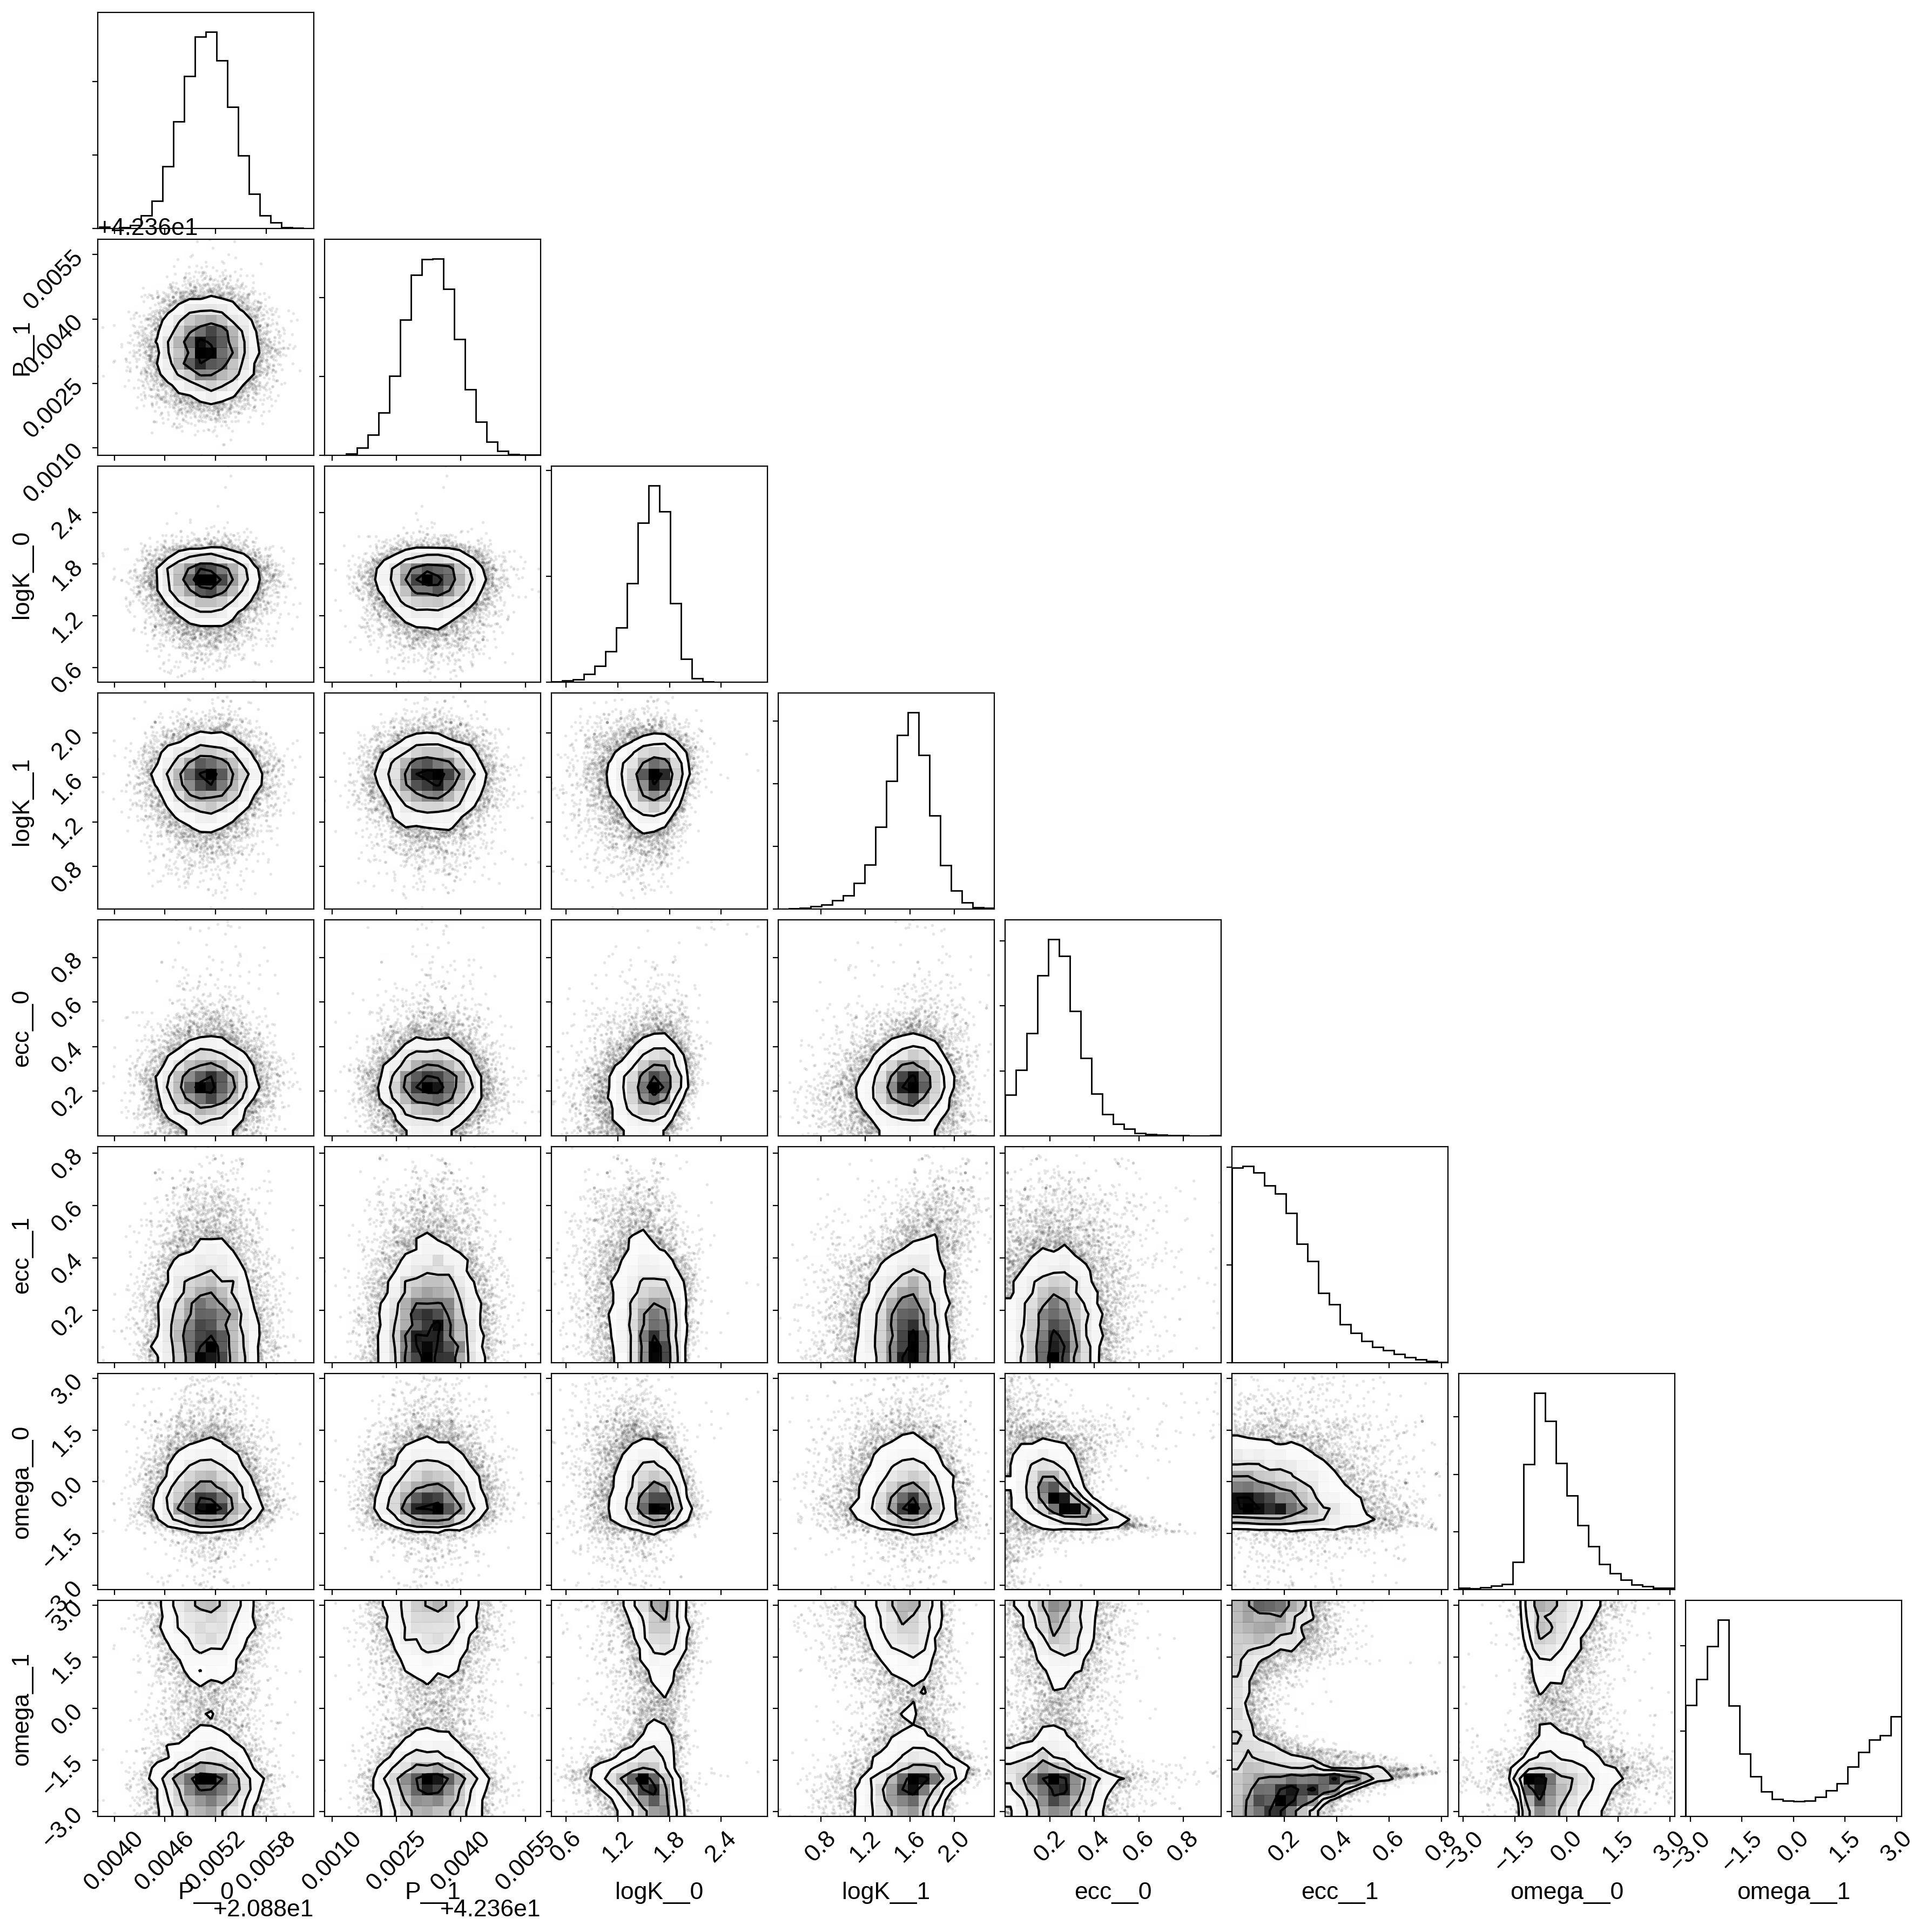

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

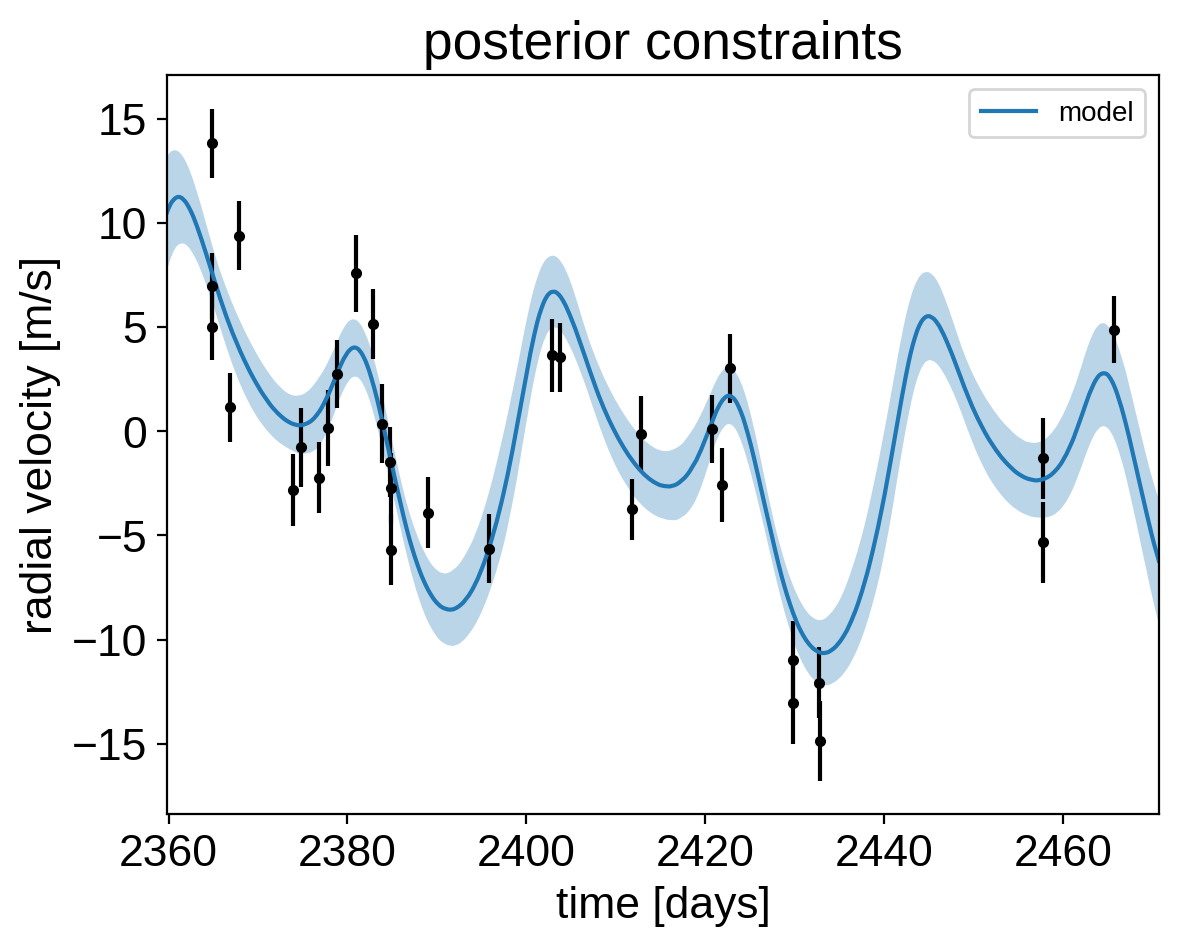

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

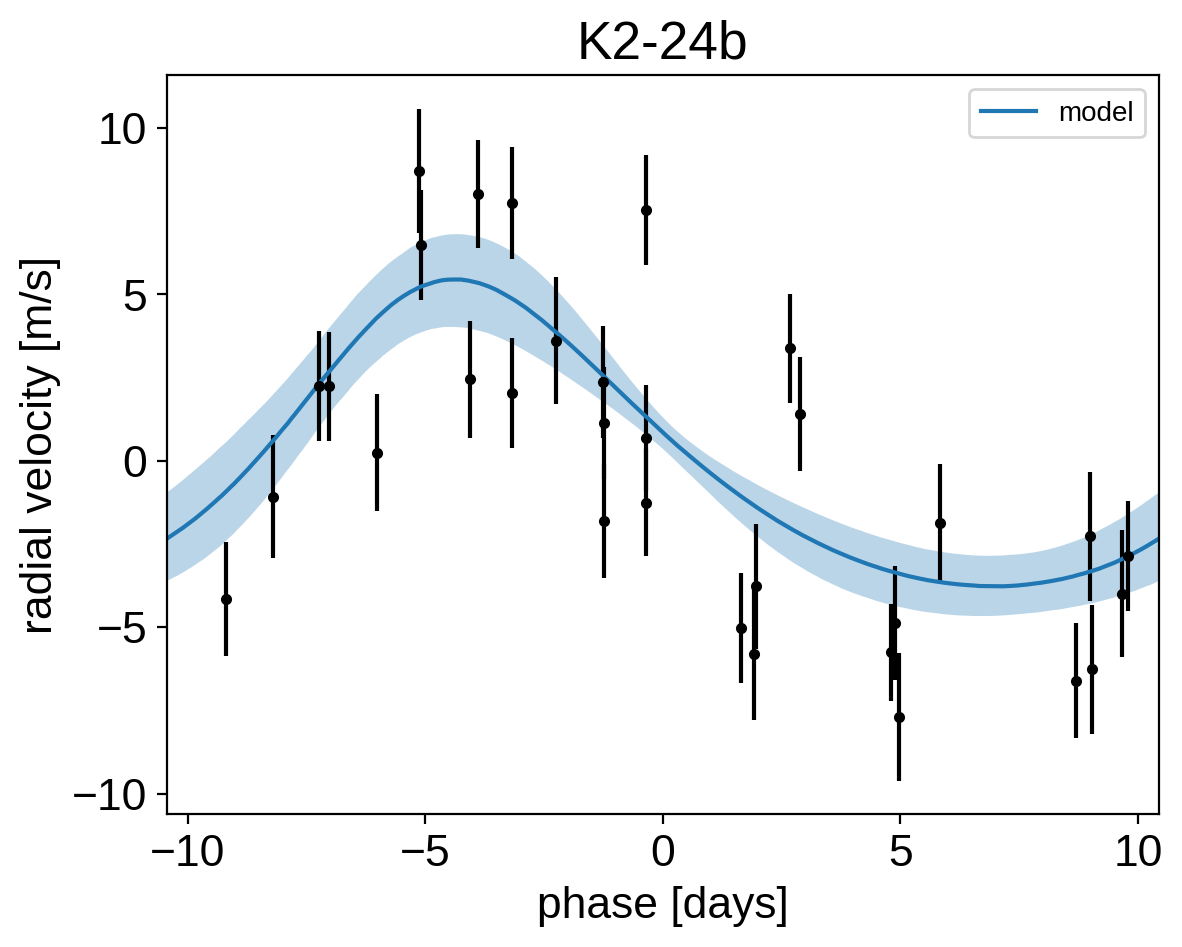

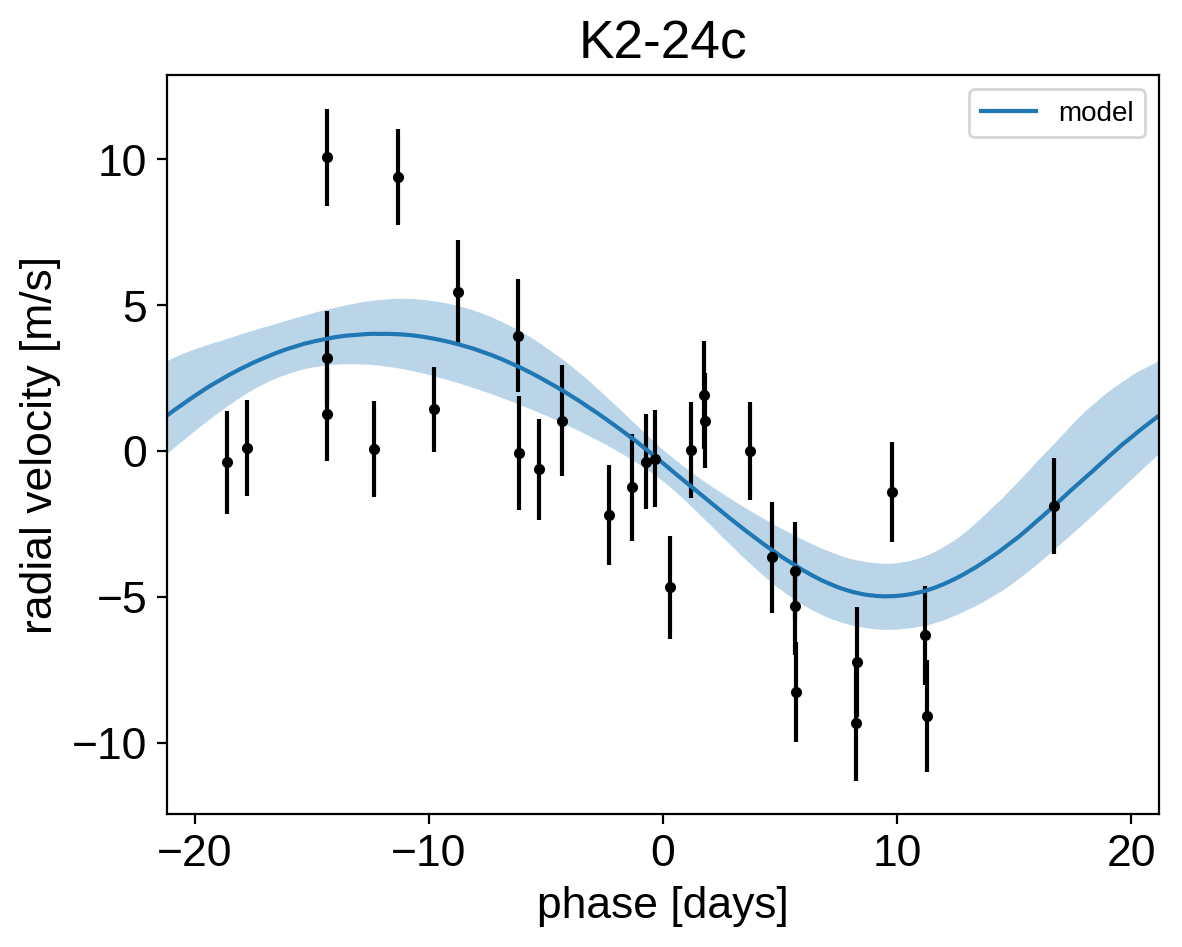

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
